In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os
import seaborn as sns

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

import sys
sys.path.insert(0, "..")

from utils import fileio
from utils import visualise
from utils import geometry
from utils import matrices
from source import segmentation_hand
from source import graham_scan

In [2]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'k',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'k',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high

In [51]:
def plot_cmap(plot_variable, cmap, save_dir, stretch, frame,title, c_label, A,B,C,R, cc ):
    #plot_variable=cell_circ_0 ###Set variable to plot

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

    ## For colormap of continuous data
    polys=plot_polys(C, R, cc)
    polys.set_facecolor('black')
    ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0.5, 1.5)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax, extend='both')
    cbar.ax.set_ylabel(c_label, rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_cell_id(cc)

    ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(save_dir+'/'+title+'.png', dpi=300)

In [3]:
inst_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Instant_data/'
inc_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Incremental_data/'
uns_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Unstretched_data/'
cont_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Continuous_data/'

In [78]:
inc_dir

'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Incremental_data/'

In [77]:
mat_dir

['C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20231005_1_IP_GFPCAAX-CheHis_us_8p6\\20231005_1_IP_GFPCAAX-CheHis_us_0p5_SP_fr001\\2024-04-30_18-32-07\\Matrices',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20231005_1_IP_GFPCAAX-CheHis_us_8p6\\20231005_1_IP_GFPCAAX-CheHis_us_1p0_SP_fr001\\2024-04-30_18-32-22\\Matrices',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20231005_1_IP_GFPCAAX-CheHis_us_8p6\\20231005_1_IP_GFPCAAX-CheHis_us_1p5_SP_fr001\\2024-04-30_18-32-37\\Matrices',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20231005_1_IP_GFPCAAX-CheHis_us_8p6\\20231005_1_IP_GFPCAAX-CheHis_us_2p0_SP_fr001\\2024-04-30_18-32-58\\Matrices',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Incremental_data/20231005_1_IP_GFPCAAX-CheHis_us_8p6\\20231005_1_IP_GFPCAAX-CheHis_us_2p5_SP_fr001\\2024-04-30_18-33-17\\Matric

In [104]:
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20240117_2_IP_GFPCAAX-CheHis_uu_0p5/*/*/Matrices'))
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_plots/20240117_2_IP_GFPCAAX-CheHis_uu_0p5/'
dat_df=pd.read_csv(uns_dir+'20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled_mech_circ.csv')

micron_size=553.57
pixel_size=1024

A_initial=np.loadtxt(glob(mat_dir[0]+'/*Matrix_A*.txt')[0])
B_initial=np.loadtxt(glob(mat_dir[0]+'/*Matrix_B*.txt')[0])
C_initial=np.loadtxt(glob(mat_dir[0]+'/*Matrix_C*.txt')[0])
R_initial=np.loadtxt(glob(mat_dir[0]+'/*Matrix_R*.txt')[0])

A_final=np.loadtxt(glob(mat_dir[-1]+'/*Matrix_A*.txt')[0])
B_final=np.loadtxt(glob(mat_dir[-1]+'/*Matrix_B*.txt')[0])
C_final=np.loadtxt(glob(mat_dir[-1]+'/*Matrix_C*.txt')[0])
R_final=np.loadtxt(glob(mat_dir[-1]+'/*Matrix_R*.txt')[0])

dat_df['first_frame'] = dat_df['tm_frame'].groupby(dat_df['cell_id_new']).transform('first')


In [176]:
dat_df

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,first_frame
0,0.0,50.909210,118.066461,4.685253,0.468980,3.0,2.598734,138.302234,169.920253,323,2915,0,0,NaN,0,0.542859,0
1,1.0,64.824634,252.644691,4.078355,0.735202,4.0,2.142655,96.180819,-194.035804,311,6423,0,0,NaN,0,0.998937,0
2,2.0,77.008177,351.130823,4.109627,0.397222,4.0,3.043790,-16.263087,-188.359549,301,6415,0,0,NaN,0,0.097802,0
3,3.0,23.868791,27.470909,4.554009,0.369148,4.0,0.362326,69.691630,-177.412486,269,6401,0,0,NaN,0,0.362326,0
4,4.0,79.113519,385.469459,4.029542,0.732870,4.0,1.301724,180.784047,-161.600062,222,6147,0,0,NaN,0,1.301724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15333,661.0,85.228952,511.572622,3.768196,0.670902,8.0,2.717864,-21.599046,225.340247,117,17218,125,25,NaN,0,0.423729,0
15334,662.0,88.850407,583.172332,3.679264,0.667870,9.0,0.158525,-240.435190,-69.119229,477,17645,125,25,NaN,0,0.158525,0
15335,663.0,96.290220,660.178550,3.747585,0.921158,9.0,1.293905,206.216993,91.137363,29,17412,125,25,NaN,0,1.293905,0
15336,664.0,90.011779,525.015833,3.928377,0.262624,9.0,2.891137,181.589855,145.196934,364,17340,125,25,NaN,0,0.250456,0


In [105]:
cec_final=geometry.get_edge_count(B_final)
cc_final=geometry.get_cell_centres(C_final, R_final, cec_final)
cec_initial=geometry.get_edge_count(B_initial)
cc_initial=geometry.get_cell_centres(C_initial, R_initial, cec_initial)

In [12]:
dat_df.columns

Index(['cell_id_old', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'cell_id_new',
       'spot_id', 'time', 'tm_frame', 'cell_perimeter_nd', 'cell_area_nd',
       'cell_P_eff_nd', 'cell_shear', 'cell_zeta',
       'major_stress_axis_alignment_rads', 'parent_id', 'divisions',
       'angle_horizontal', 'circ_J', 'circ_P', 'circ_A', 'shape_axis_J',
       'shape_axis_P', 'shape_axis_A', 'first_frame'],
      dtype='object')

In [106]:
def get_conditions(df):
    conditions = [
    (df.cell_id_new.isin(np.unique(df.parent_id)[:-1])),
    (~df.cell_id_new.isin(np.unique(df.parent_id)[:-1]))&(df.divisions==0),
    (df.divisions>0)
    ]

    return conditions
values = ['will divide', 'never divides', 'daughter cell']

dat_df['state'] = np.select(get_conditions(dat_df), values)
dat_df['last_frame']=dat_df[(dat_df.state=='will divide')].groupby('cell_id_new').time.transform('last')


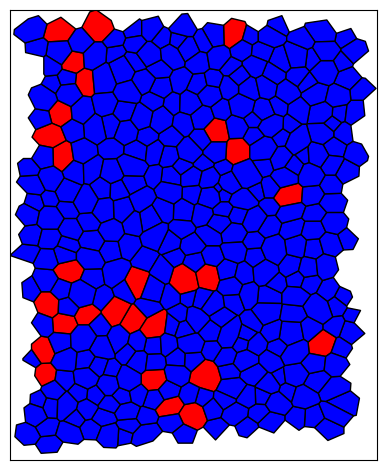

In [107]:
plot_variable=dat_df[dat_df.time==0].state
cmap='bwr' 
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.set_xlim(np.min(cc_initial[:,0])-30, np.max(cc_initial[:,0])+30)
ax.set_ylim(np.min(cc_initial[:,1])-30, np.max(cc_initial[:,1])+30)


N_c=np.shape(C_initial)[0]
patches = []
patchesdiv = []
patchesnodiv = []

for i in range(N_c):
    polygon = make_polygon(i, C_initial, R_initial, cc_initial)
    patches.append(polygon)
    
    if plot_variable[i] =='will divide':
        polygondiv = polygon
        patchesdiv.append(polygondiv)
    else:
        polygonnodiv = polygon
        patchesnodiv.append(polygonnodiv)

polydiv=PatchCollection(patchesdiv)
polynodiv=PatchCollection(patchesnodiv)

nodivc='blue' ###Choose low value colour here
divc='red' ###Choose high value colour here
polynodiv.set_edgecolor('black')
polydiv.set_edgecolor('black')
polydiv.set_facecolor(divc) 
ax.add_collection(polydiv)
polynodiv.set_facecolor(nodivc) 
ax.add_collection(polynodiv)






ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

#plot_edges(A_final, R_final)

#plot_cell_id(cc)

#ax.set_title(title) ###change title
plt.gca().set_aspect('equal')
plt.tight_layout()

##uncomment to save
plt.savefig(plot_dir+'/cells_will_div.png', dpi=300)

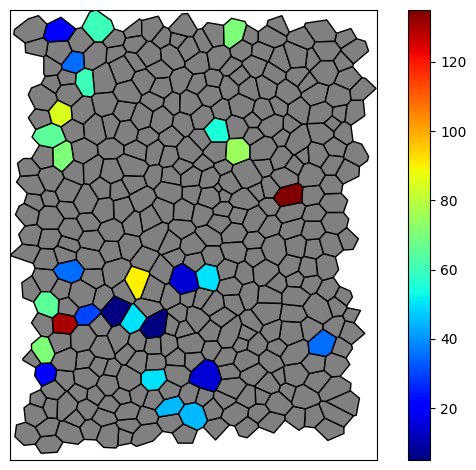

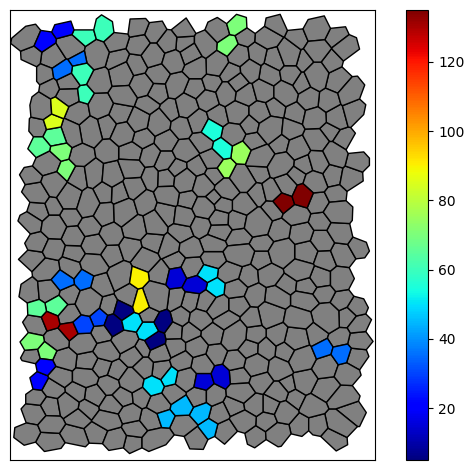

In [108]:
plot_variable=dat_df[dat_df.time==0].state
cmap='jet' 
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.set_xlim(np.min(cc_initial[:,0])-30, np.max(cc_initial[:,0])+30)
ax.set_ylim(np.min(cc_initial[:,1])-30, np.max(cc_initial[:,1])+30)


N_c=np.shape(C_initial)[0]
patches = []
patchesdiv = []
patchesnodiv = []

for i in range(N_c):
    polygon = make_polygon(i, C_initial, R_initial, cc_initial)
    patches.append(polygon)
    
    if plot_variable[i] =='will divide':
        polygondiv = polygon
        patchesdiv.append(polygondiv)
    else:
        polygonnodiv = polygon
        patchesnodiv.append(polygonnodiv)

polydiv=PatchCollection(patchesdiv)
polynodiv=PatchCollection(patchesnodiv)

nodivc='grey' ###Choose low value colour here
polynodiv.set_edgecolor('black')
polydiv.set_edgecolor('black')
# polydiv.set_facecolor(divc) 
# ax.add_collection(polydiv)
polynodiv.set_facecolor(nodivc) 
ax.add_collection(polynodiv)

div_time=dat_df[(dat_df.state=='will divide')&(dat_df.time==0)].last_frame + 5

polydiv.set_array(div_time)

polydiv.set_cmap(cmap) ###set polygon colourmap here
polydiv.set_clim(np.min(div_time),np.max(div_time))
ax.add_collection(polydiv) 
cbar=fig.colorbar(polydiv,
          ax=ax)
#cbar.ax.set_ylabel('first_frame', rotation=90) ###set colorbar label





ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

#plot_edges(A_final, R_final)

#plot_cell_id(cc)

#ax.set_title(title) ###change title
plt.gca().set_aspect('equal')
plt.tight_layout()

##uncomment to save
plt.savefig(plot_dir+'/cells_will_div_time.png', dpi=300)



plot_variable=dat_df[dat_df.time==np.max(dat_df.time)].state.values
cmap='jet' 
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.set_xlim(np.min(cc_final[:,0])-30, np.max(cc_final[:,0])+30)
ax.set_ylim(np.min(cc_final[:,1])-30, np.max(cc_final[:,1])+30)


N_c=np.shape(C_final)[0]
patches = []
patchesdiv = []
patchesnodiv = []

for i in range(N_c):
    polygon = make_polygon(i, C_final, R_final, cc_final)
    patches.append(polygon)
    
    if plot_variable[i] =='daughter cell':
        polygondiv = polygon
        patchesdiv.append(polygondiv)
    else:
        polygonnodiv = polygon
        patchesnodiv.append(polygonnodiv)

polydiv=PatchCollection(patchesdiv)
polynodiv=PatchCollection(patchesnodiv)

nodivc='grey' ###Choose low value colour here
polynodiv.set_edgecolor('black')
polydiv.set_edgecolor('black')
# polydiv.set_facecolor(divc) 
# ax.add_collection(polydiv)
polynodiv.set_facecolor(nodivc) 
ax.add_collection(polynodiv)

div_time=dat_df[(dat_df.state=='daughter cell')&(dat_df.time==np.max(dat_df.time))].first_frame*5

polydiv.set_array(div_time)

polydiv.set_cmap(cmap) ###set polygon colourmap here
polydiv.set_clim(np.min(div_time),np.max(div_time))
ax.add_collection(polydiv) 
cbar=fig.colorbar(polydiv,
          ax=ax)
#cbar.ax.set_ylabel('first_frame', rotation=90) ###set colorbar label





ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

#plot_edges(A_final, R_final)

#plot_cell_id(cc)

#ax.set_title(title) ###change title
plt.gca().set_aspect('equal')
plt.tight_layout()

##uncomment to save
plt.savefig(plot_dir+'/cells_daughter_time.png', dpi=300)

In [41]:
div_time

12713    140
12715     50
12716      5
12720     40
12723    100
        ... 
13105     20
13106      5
13117      5
13142      5
13156      5
Name: first_frame, Length: 82, dtype: int64

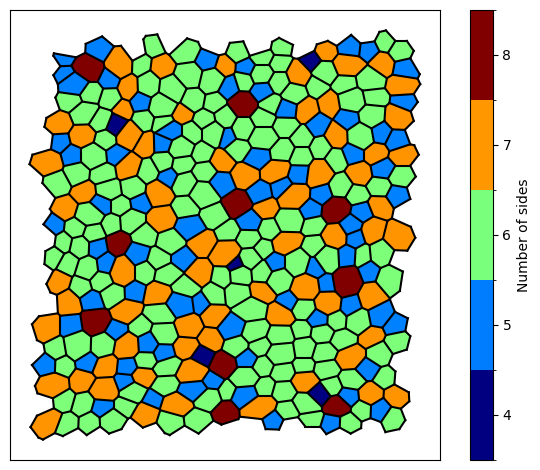

In [12]:
plot_variable=dat_df[dat_df.time==np.max(dat_df.time)].cell_edge_count
#cmap='rainbow' 
cmap = mpl.cm.jet ###choose colour map to discretise here
bounds = np.arange(plot_variable.min()-0.5, plot_variable.max()+1.5, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

## For colormap of continuous data
# polys=plot_polys(C, R, cc)
# polys.set_facecolor('black')
# ax.add_collection(polys) 

polys=plot_polys(C_final, R_final, cc_final)
#polys.set_facecolor('black')
polys.set_array(plot_variable)
polys.set_cmap(cmap) ###set polygon colourmap here
#polys.set_clim(0.5, 1.5)
ax.add_collection(polys) 
#cbar = fig.colorbar(polys, ax=ax)

cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, ticks=np.arange(plot_variable.min(), plot_variable.max()+1, 1))
#cbar.ax.set_ylabel('Number of Divisions', rotation=90) ###set colorbar label




cbar.ax.set_ylabel('Number of sides', rotation=90) ###set colorbar label


ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

plot_edges(A_final, R_final)

#plot_cell_id(cc)

#ax.set_title(title) ###change title
plt.gca().set_aspect('equal')
plt.tight_layout()

In [37]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].cell_edge_count
    #cmap='rainbow' 
    cmap = mpl.cm.jet ###choose colour map to discretise here
    bounds = np.arange(dat_df.cell_edge_count.min()-0.5, dat_df.cell_edge_count.max()+1.5, 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(dat_df.cell_edge_count.min(),dat_df.cell_edge_count.max())
    ax.add_collection(polys) 
    #cbar = fig.colorbar(polys, ax=ax)
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, ticks=np.arange(dat_df.cell_edge_count.min(), dat_df.cell_edge_count.max()+1, 1))
    cbar.ax.set_ylabel('Number of sides', rotation=90) ###set colorbar label


    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/edge_count_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

<AxesSubplot: xlabel='circularity', ylabel='Count'>

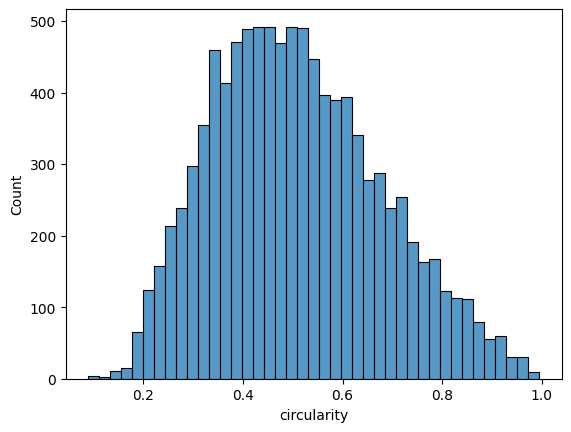

In [14]:
sns.histplot(data=dat_df, x='circularity')

In [38]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].divisions
    cmap='bwr' 
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, 1)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('Number of Divisions', rotation=90) ###set colorbar label


    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))


    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/divisions_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [182]:
sns.color_palette("mako", 26)

[(0.08212852, 0.0400833, 0.06970862),
 (0.11761516, 0.06824548, 0.12116393),
 (0.15540398, 0.09670855, 0.18094993),
 (0.18501213, 0.12245547, 0.23781116),
 (0.21220409, 0.15231929, 0.30354703),
 (0.23142077, 0.18058733, 0.3644173),
 (0.2467815, 0.21348266, 0.43393244),
 (0.25386167, 0.24506548, 0.49679407),
 (0.24958205, 0.28556371, 0.55701246),
 (0.23644557, 0.32699241, 0.59240198),
 (0.22152555, 0.37424409, 0.61304472),
 (0.21288172, 0.41555771, 0.62373011),
 (0.20849798, 0.46005094, 0.63315928),
 (0.20578999, 0.49953341, 0.64222457),
 (0.20372653, 0.54325208, 0.65251978),
 (0.20384884, 0.58264293, 0.6612145),
 (0.20877302, 0.62649546, 0.66940555),
 (0.220668, 0.66594665, 0.67485792),
 (0.24549008, 0.70957083, 0.67835215),
 (0.27822463, 0.74860229, 0.67914468),
 (0.33437168, 0.79042043, 0.67734882),
 (0.41730243, 0.82318339, 0.67735255),
 (0.53447549, 0.85179048, 0.69561066),
 (0.63140509, 0.87600675, 0.72741689),
 (0.72606665, 0.90374337, 0.7800041),
 (0.8008109, 0.93083672, 0.83829355)]

In [39]:
cmap = mpl.cm.jet ###choose colour map to discretise here
bounds = np.arange(dat_df.first_frame.min()-0.5, dat_df.first_frame.max()+1.5, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].first_frame

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(dat_df.first_frame.min(),dat_df.first_frame.max())
    ax.add_collection(polys) 
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, ticks=np.arange(dat_df.first_frame.min(), dat_df.first_frame.max()+1, 1))
    cbar.ax.set_ylabel('first_frame', rotation=90) ###set colorbar label


    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))


    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/divisions_by frame_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [40]:
cyclic=sns.hls_palette(h=0.0, l=0.5, s=1, as_cmap=True)
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads
    cmap=cyclic
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, np.pi)
    polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('angle', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/angle_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [41]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].circularity
    cmap='Blues_r'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, 1)
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('circularity', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/circularity_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [42]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].cell_zeta
    cmap='plasma'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, dat_df.cell_zeta.max())
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('zeta', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/shear_strain_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [35]:
dat_df.cell_zeta.max()

0.291970496129779

In [43]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].cell_area_microns
    cmap='Reds'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(dat_df.cell_area_microns.min(), dat_df.cell_area_microns.max())
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('cell area (microns)', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].shape_axis_P))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/cell_area_microns_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [33]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].circ_P
    cmap='Blues_r'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, 1)
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('circularity', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].shape_axis_P))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/circ_P_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [44]:

for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)
    shell_matrix=np.loadtxt(glob(mat_dir[i]+'/*shell*.txt')[0])

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values,dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values))**2
    dot_product = shape_cos_sq*np.abs(np.multiply.outer((dat_df[dat_df.tm_frame==i].circularity.values-1), (dat_df[dat_df.tm_frame==i].circularity.values-1)))

    plot_variable=[np.mean(shape_cos_sq[x,np.where((shell_matrix[x]==1))]) for x in range(len(shell_matrix))]

    cmap='bwr'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)


    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, 1)
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('alignment with nearest neighbours', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/bwr_neighbour_alignment_1_shell_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [45]:

for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)
    shell_matrix=np.loadtxt(glob(mat_dir[i]+'/*shell*.txt')[0])

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==i].shape_axis_P.values,dat_df[dat_df.tm_frame==i].shape_axis_P.values))**2
    #dot_product = shape_cos_sq*np.abs(np.multiply.outer((dat_df[dat_df.tm_frame==i].circularity.values-1), (dat_df[dat_df.tm_frame==i].circularity.values-1)))

    plot_variable=[np.mean(shape_cos_sq[x,np.where((shell_matrix[x]==1))]) for x in range(len(shell_matrix))]

    cmap='bwr'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)


    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, 1)
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('alignment with nearest neighbours', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    ax.set_title("perimeter shape axis") ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/bwr_perimeter_angle_neighbour_alignment_1_shell_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [46]:

for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)
    shell_matrix=np.loadtxt(glob(mat_dir[i]+'/*shell*.txt')[0])

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values,dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values))**2
    dot_product = shape_cos_sq*np.abs(np.multiply.outer((dat_df[dat_df.tm_frame==i].circularity.values-1), (dat_df[dat_df.tm_frame==i].circularity.values-1)))

    plot_variable=[np.mean(shape_cos_sq[x,np.where((shell_matrix[x]==1)|(shell_matrix[x]==2))]) for x in range(len(shell_matrix))]

    cmap='bwr'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)


    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, 1)
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('alignment with neighbours (2 shells)', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/bwr_neighbour_alignment_2_shells_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [47]:

for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)
    shell_matrix=np.loadtxt(glob(mat_dir[i]+'/*shell*.txt')[0])

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values,dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads.values))**2
    dot_product = shape_cos_sq*np.abs(np.multiply.outer((dat_df[dat_df.tm_frame==i].circularity.values-1), (dat_df[dat_df.tm_frame==i].circularity.values-1)))

    plot_variable=[np.mean(shape_cos_sq[x,:]) for x in range(len(shell_matrix))]

    cmap='bwr'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)


    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(0, 1)
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('alignment', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/bwr_neighbour_alignment_all_shells_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [26]:
cc

array([[ 1.18965123e+02, -1.42176509e+02],
       [-1.75352919e+01, -4.89237504e+01],
       [-2.10798256e+02, -4.79777080e+01],
       [-6.72700966e+01,  8.09543672e+01],
       [ 8.25289728e+01, -1.61340627e+02],
       [ 1.67510617e+02, -1.63827367e+02],
       [-1.52413920e+02, -1.62962414e+02],
       [-1.81299472e+01, -1.50744951e+02],
       [-4.71058769e+01, -1.39608680e+02],
       [ 1.74430242e+02, -1.38527488e+02],
       [ 7.96097560e+01, -1.27823693e+02],
       [-1.34141785e+02, -1.25336953e+02],
       [ 1.56032247e+01, -1.20795949e+02],
       [-1.67010004e+02, -1.20795949e+02],
       [-1.50359656e+02, -1.19498519e+02],
       [ 1.90539994e+02, -1.15714350e+02],
       [ 1.14532238e+02, -1.11605822e+02],
       [ 1.61239707e+02, -1.09227201e+02],
       [-8.28933124e+01, -1.07064818e+02],
       [ 2.00378836e+02, -1.04361840e+02],
       [ 8.57725470e+01, -1.00469551e+02],
       [ 6.49055528e+01, -9.50635937e+01],
       [-2.22367004e+02, -9.31174492e+01],
       [-1.

In [28]:

for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)
    shell_matrix=np.loadtxt(glob(mat_dir[i]+'/*shell*.txt')[0])

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.tm_frame==i].shape_axis_P.values,dat_df[dat_df.tm_frame==i].shape_axis_P.values))**2
    #dot_product = shape_cos_sq*np.abs(np.multiply.outer((dat_df[dat_df.tm_frame==i].circularity.values-1), (dat_df[dat_df.tm_frame==i].circularity.values-1)))
    r=cdist(cc,cc)

    plot_variable=[np.mean(r[x,np.where((shell_matrix[x]==1))]) for x in range(len(shell_matrix))]

    cmap='viridis'
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)


    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(15, 34)
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('mean cell radius', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    ax.set_title("mean cell radius") ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/mean_cell_dist_1_shell_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_17648\4238606741.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax=plt.subplots(frameon=False,figsize=(10,10), dpi=102.4,subplot_kw={'aspect': 'equal'})


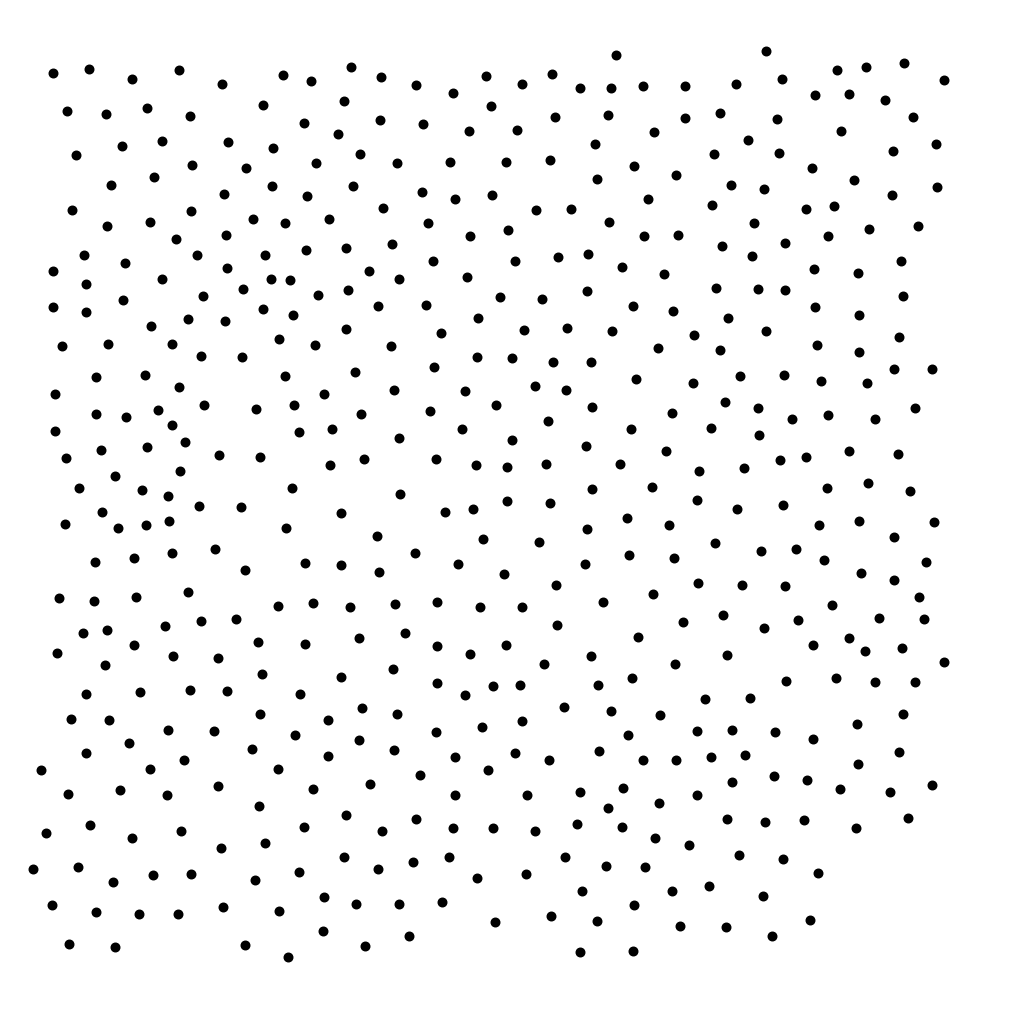

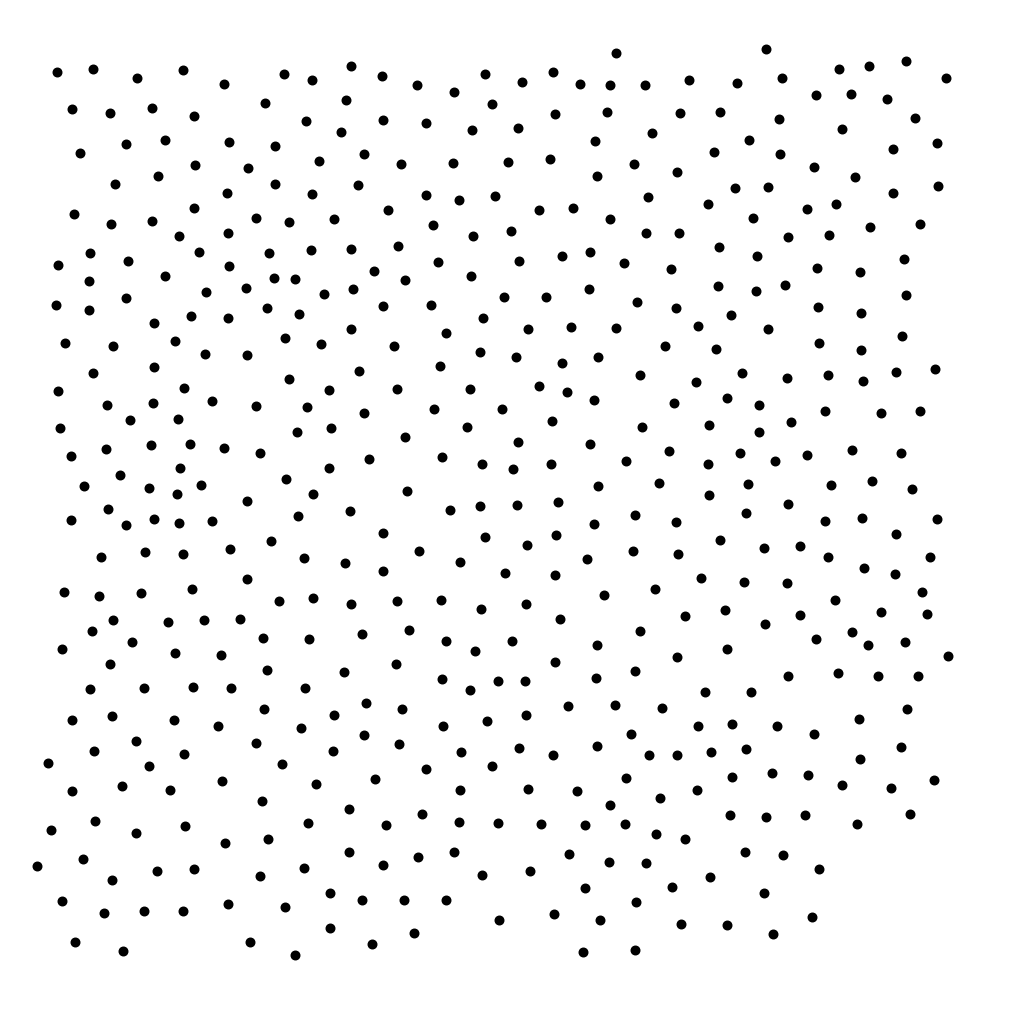

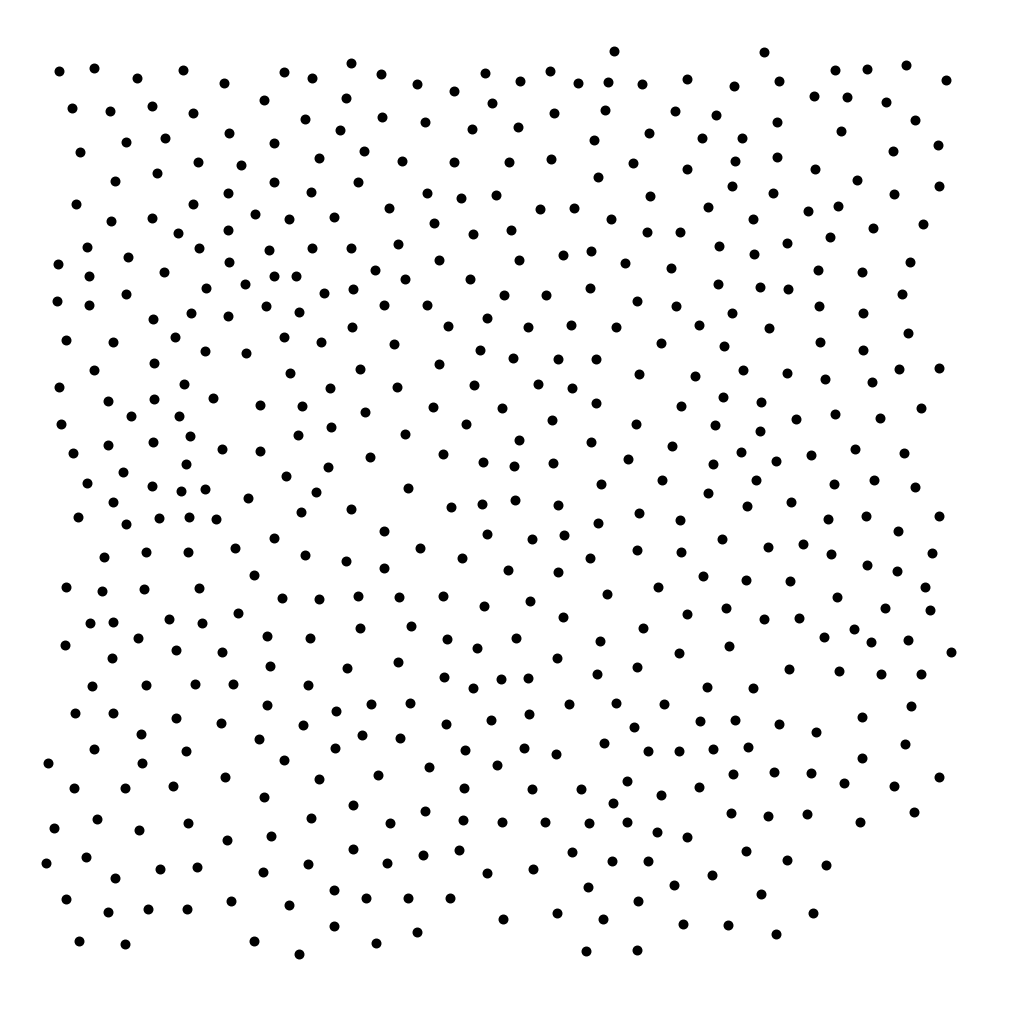

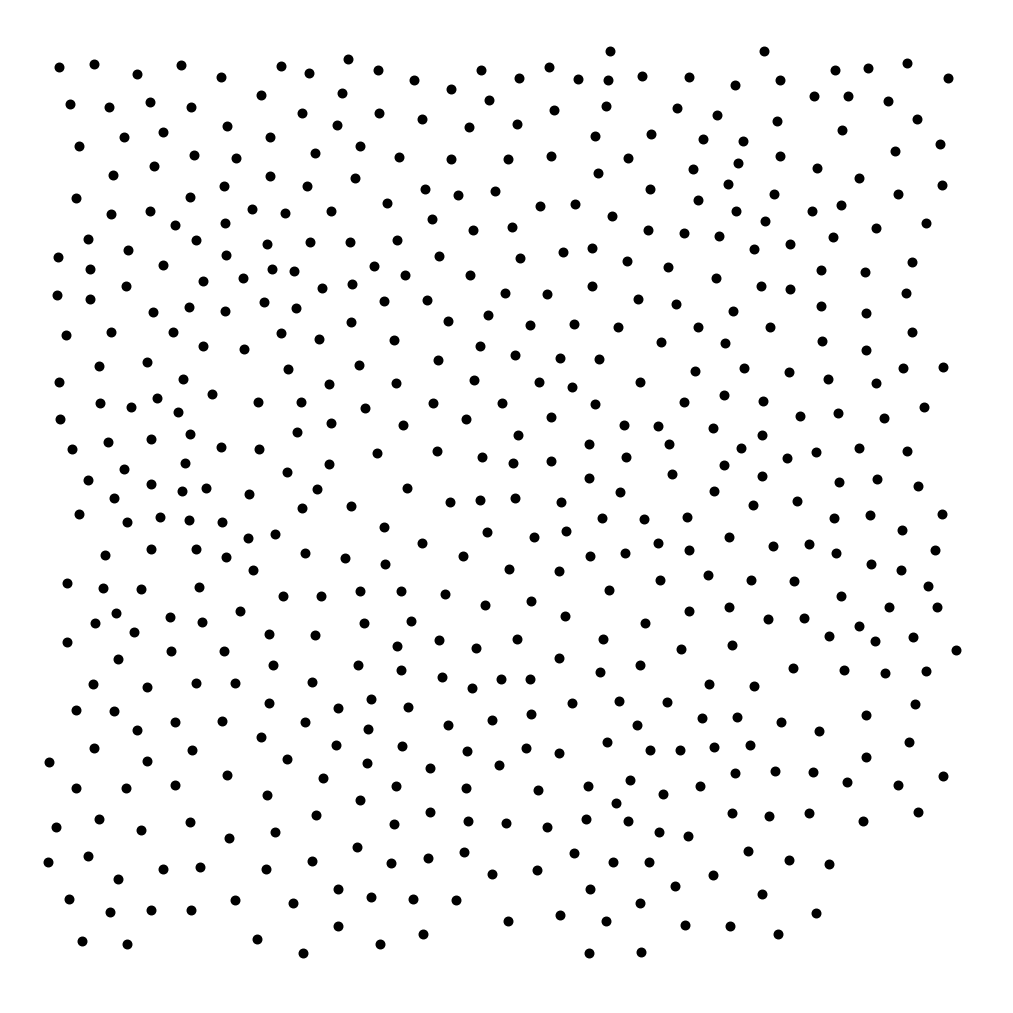

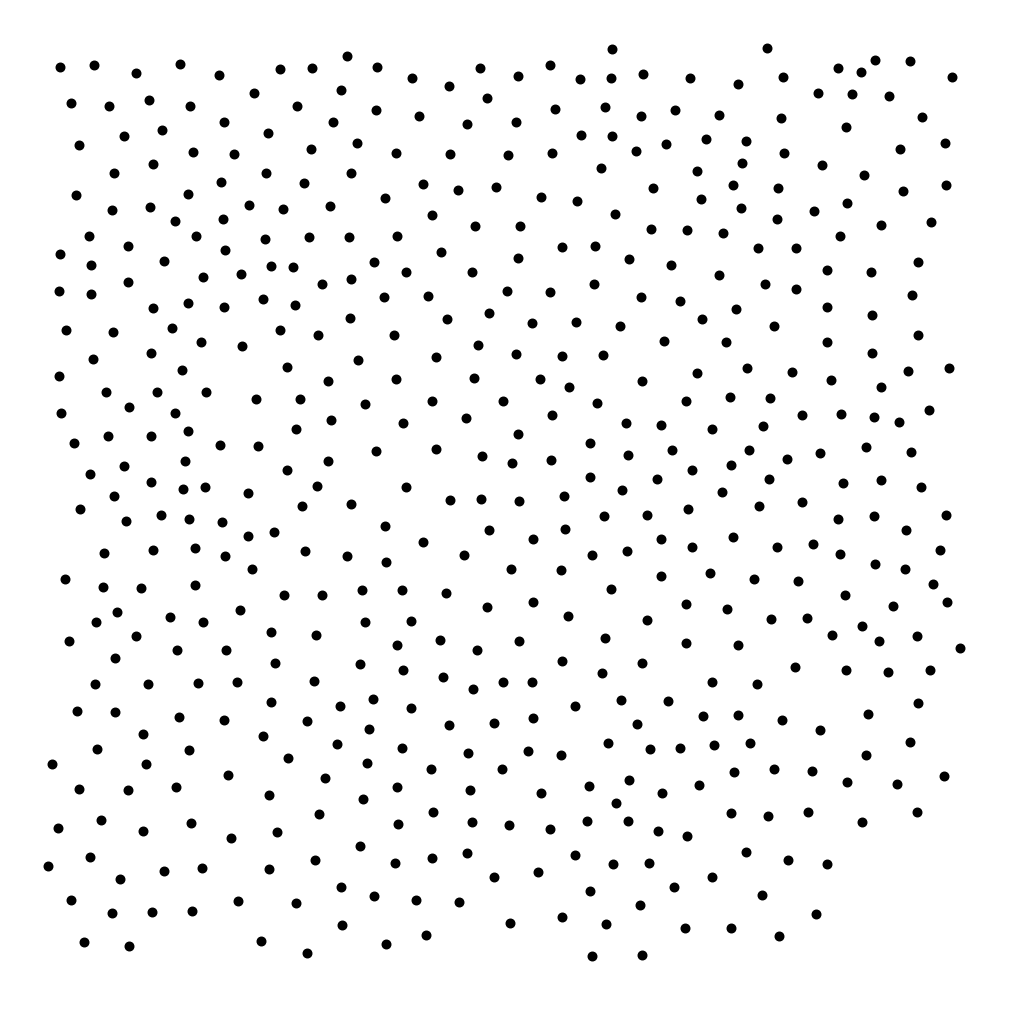

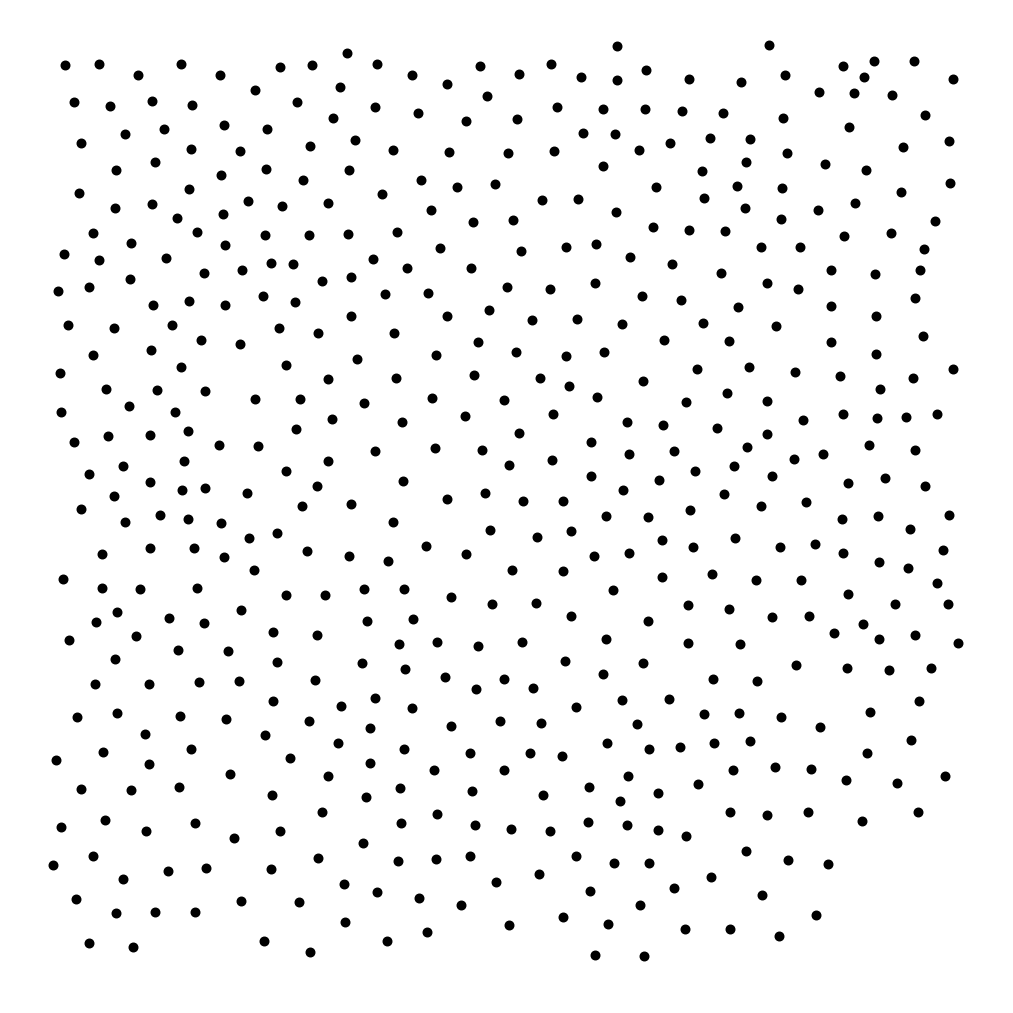

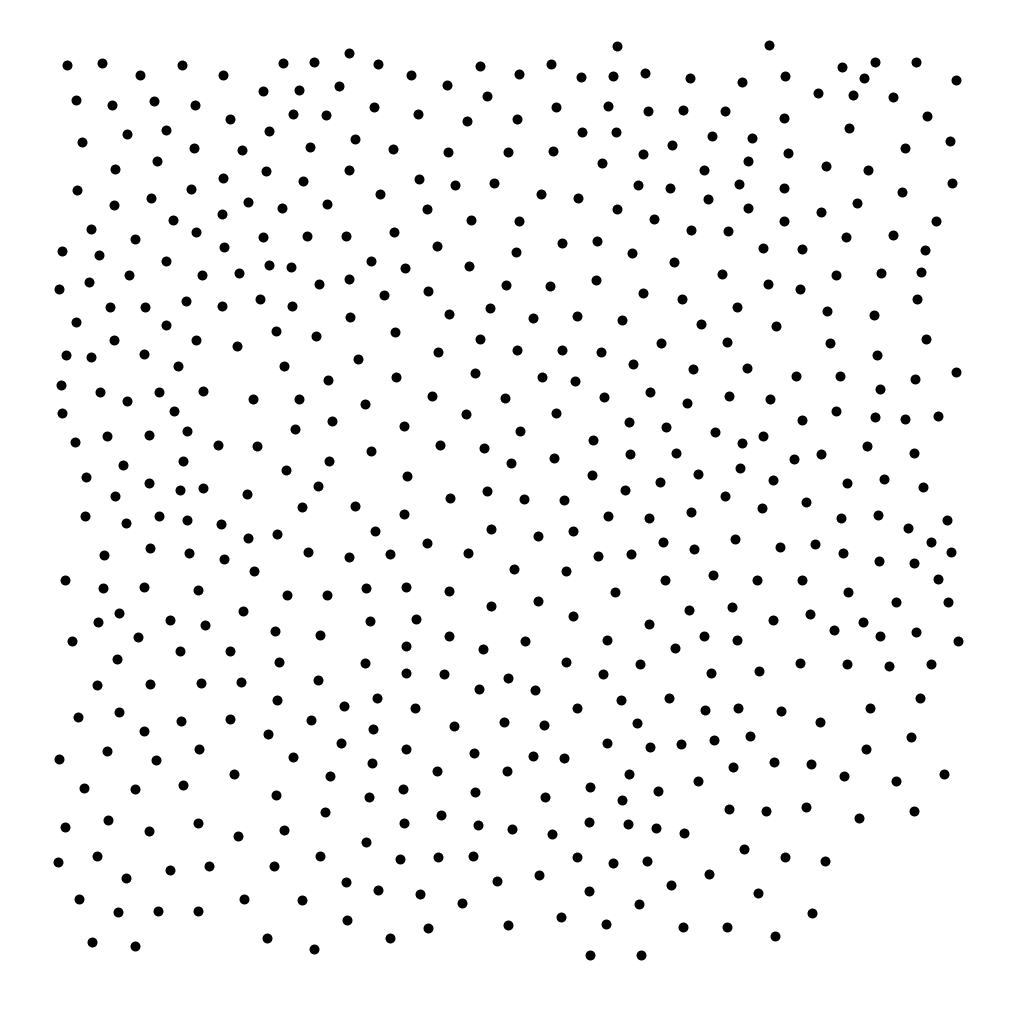

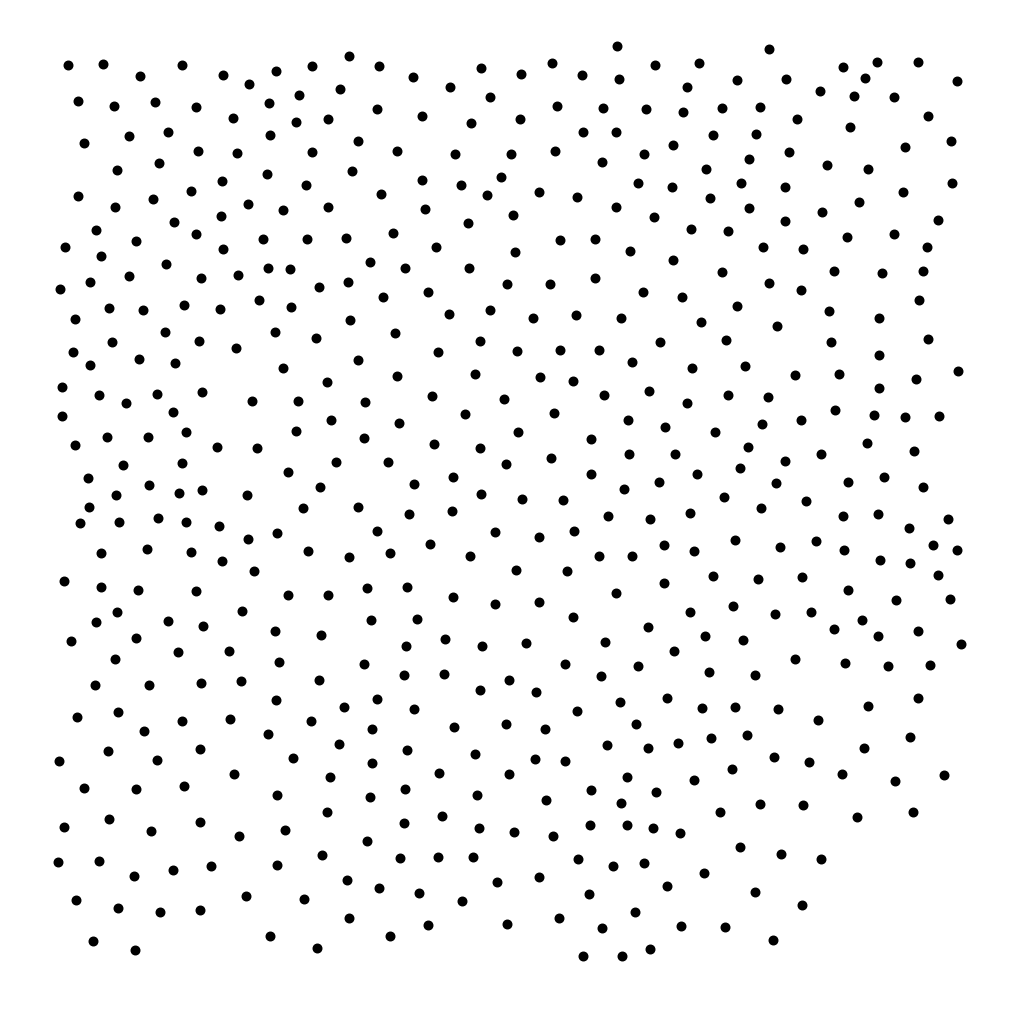

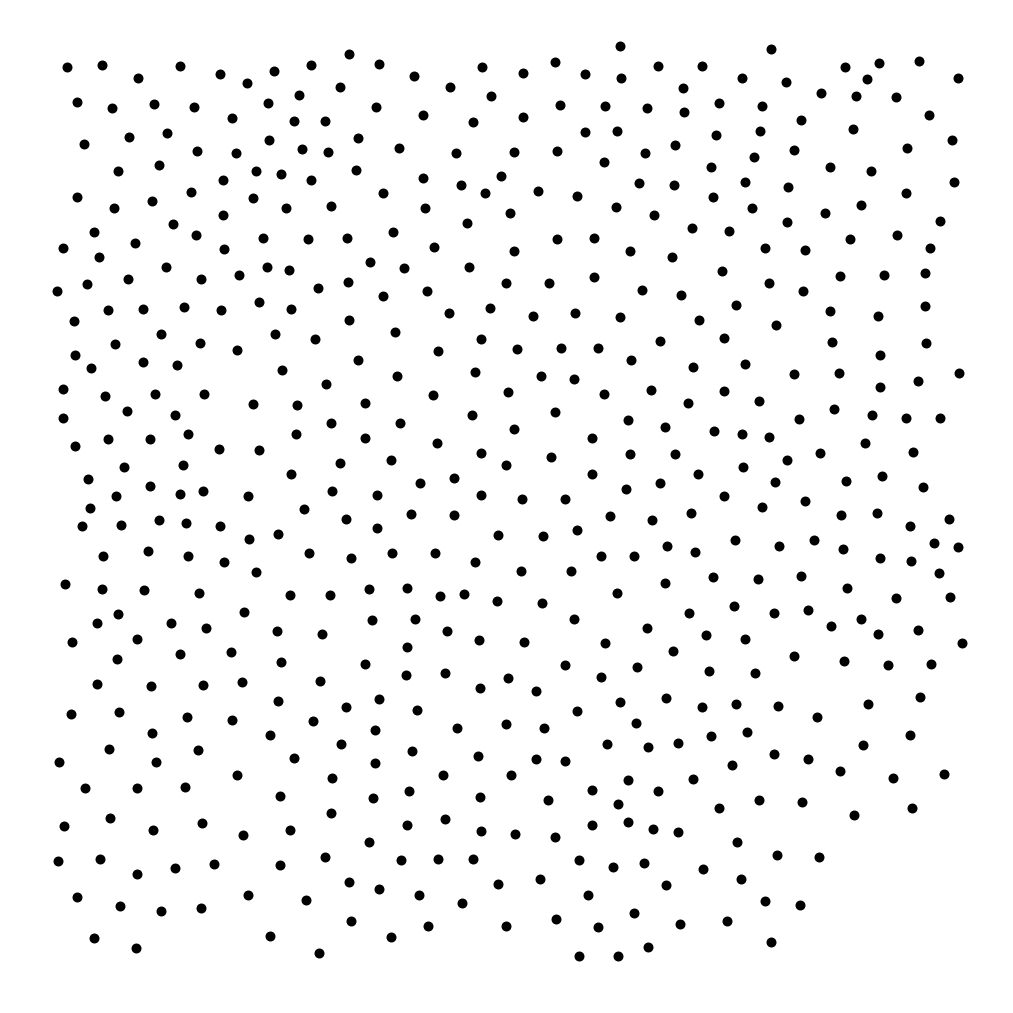

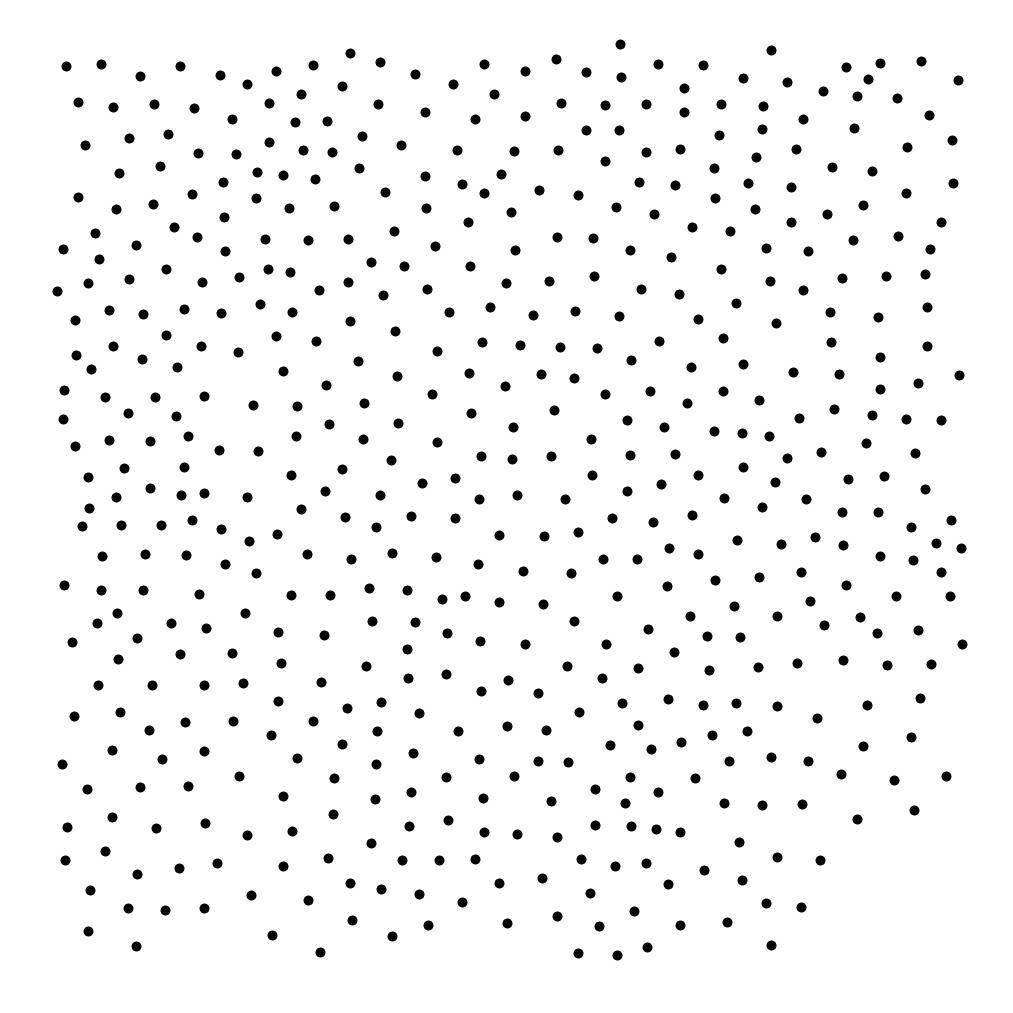

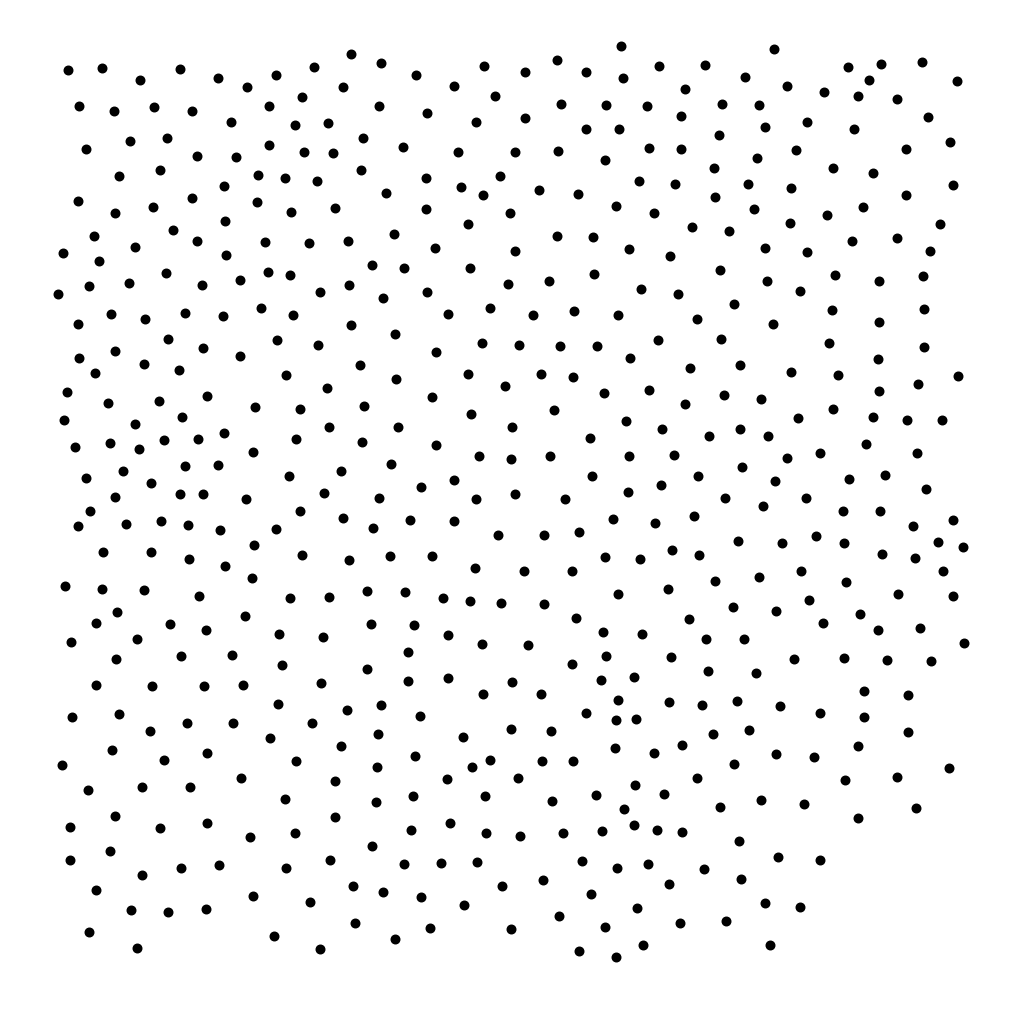

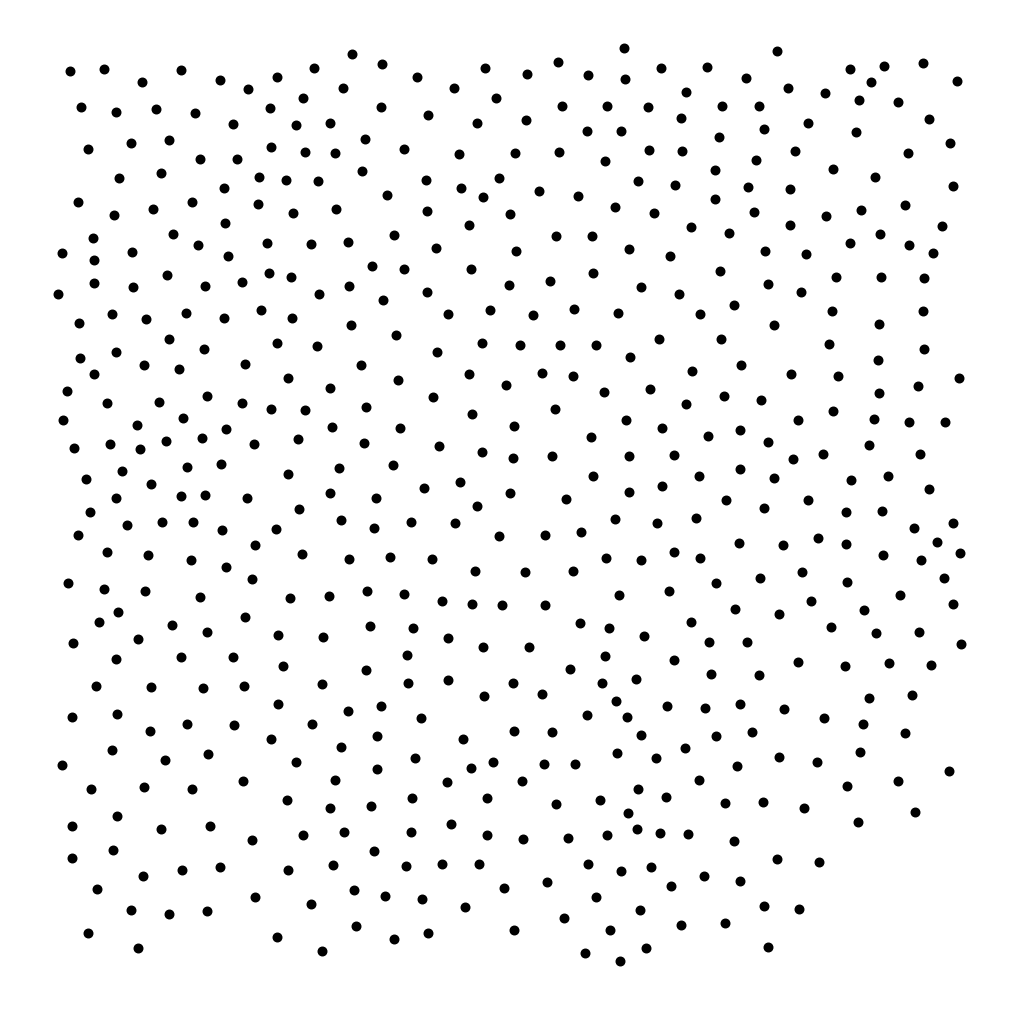

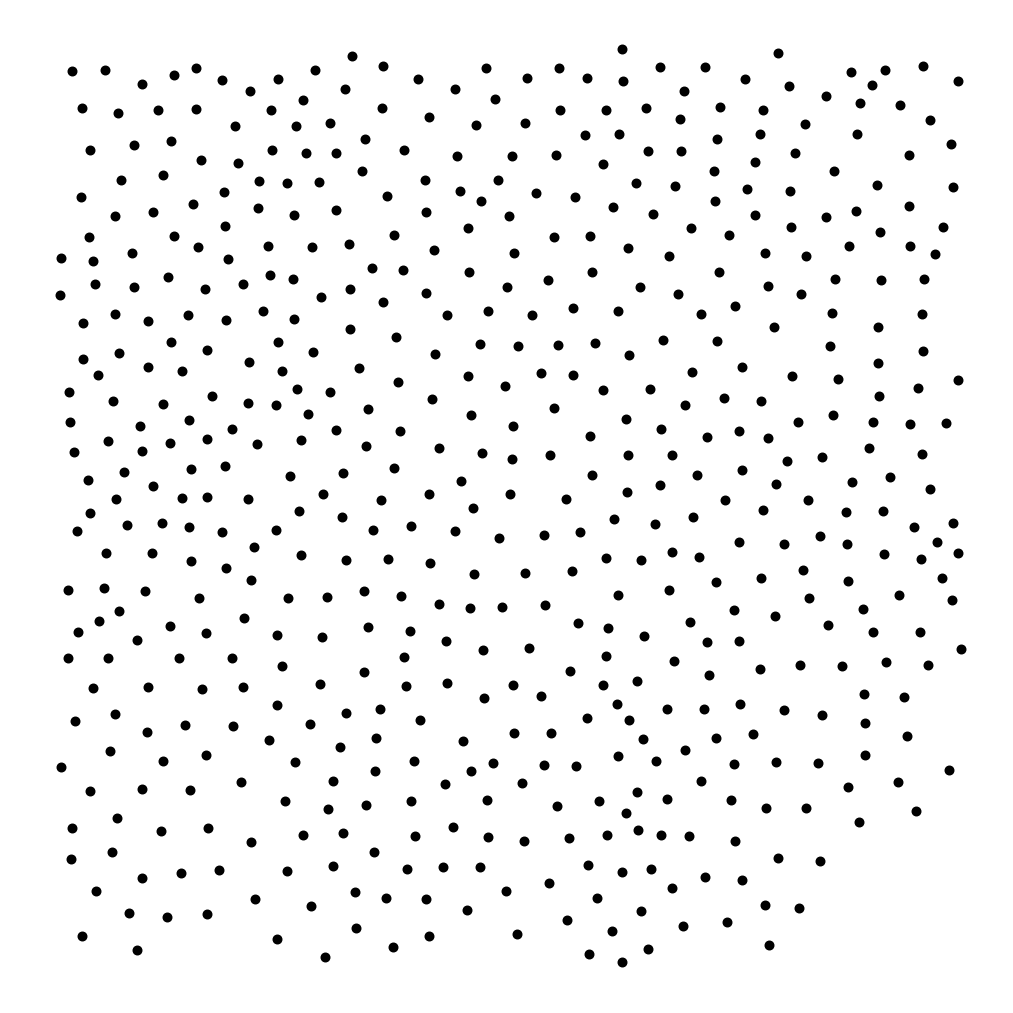

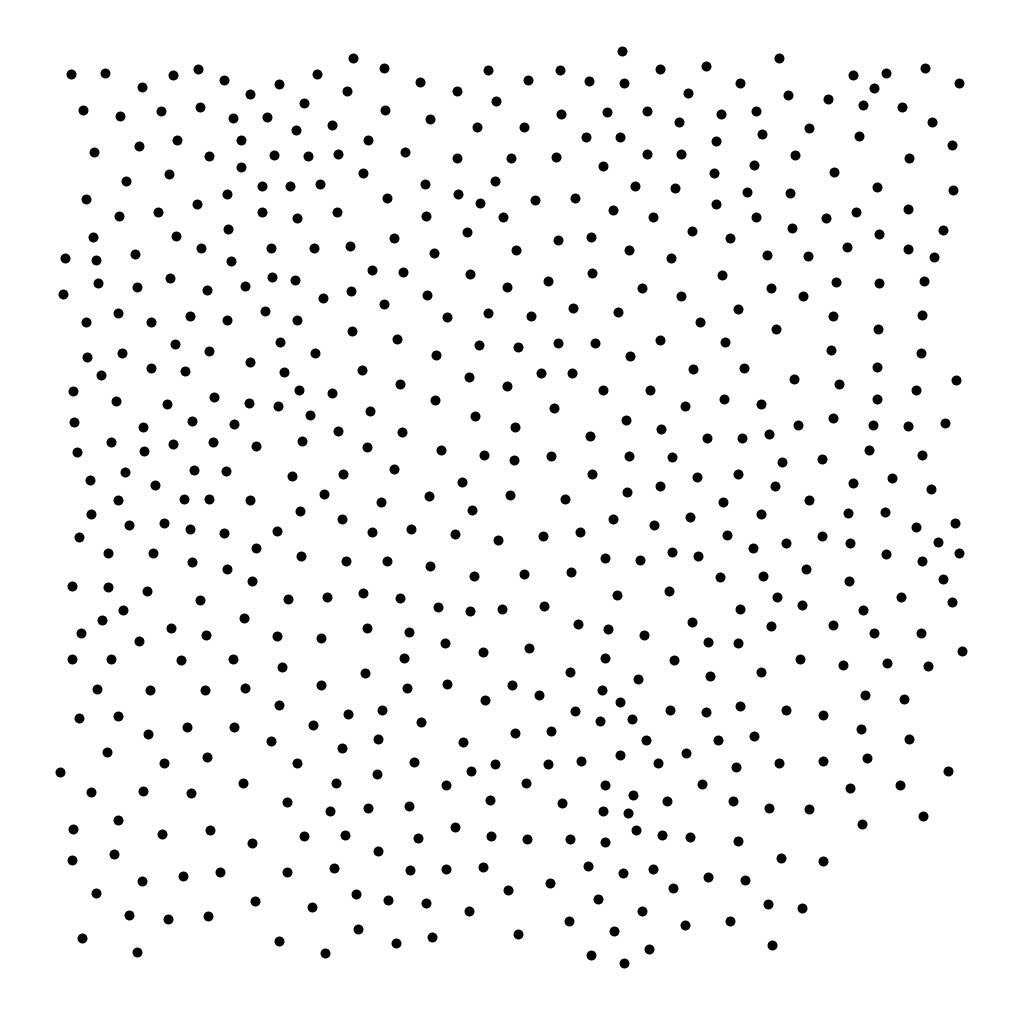

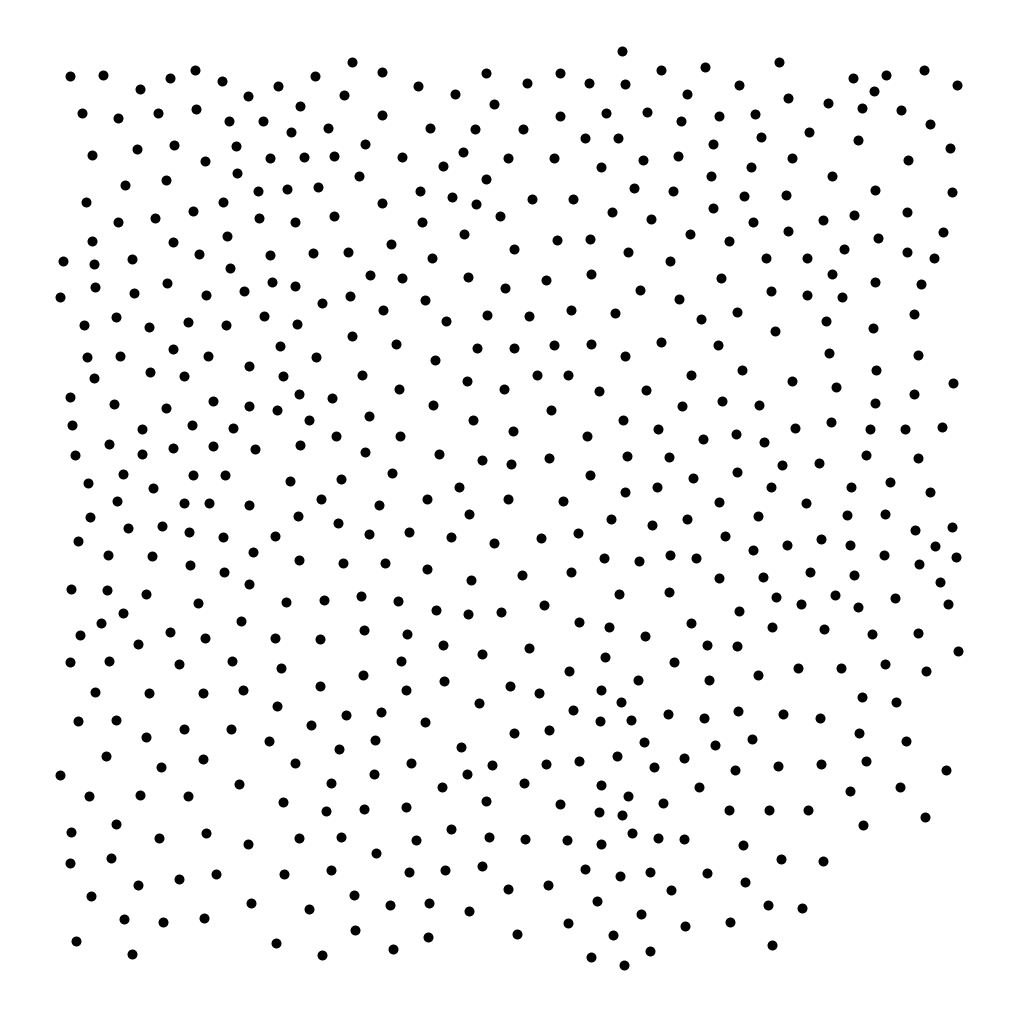

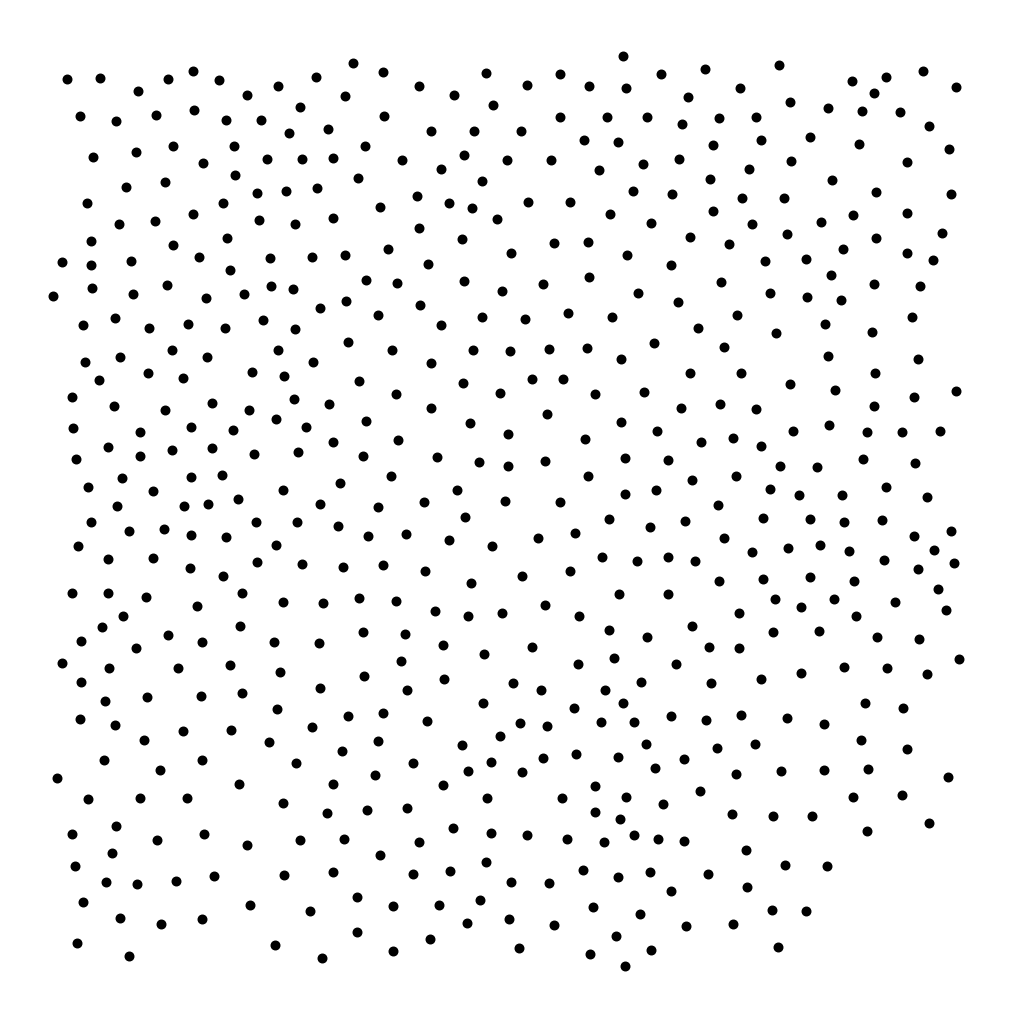

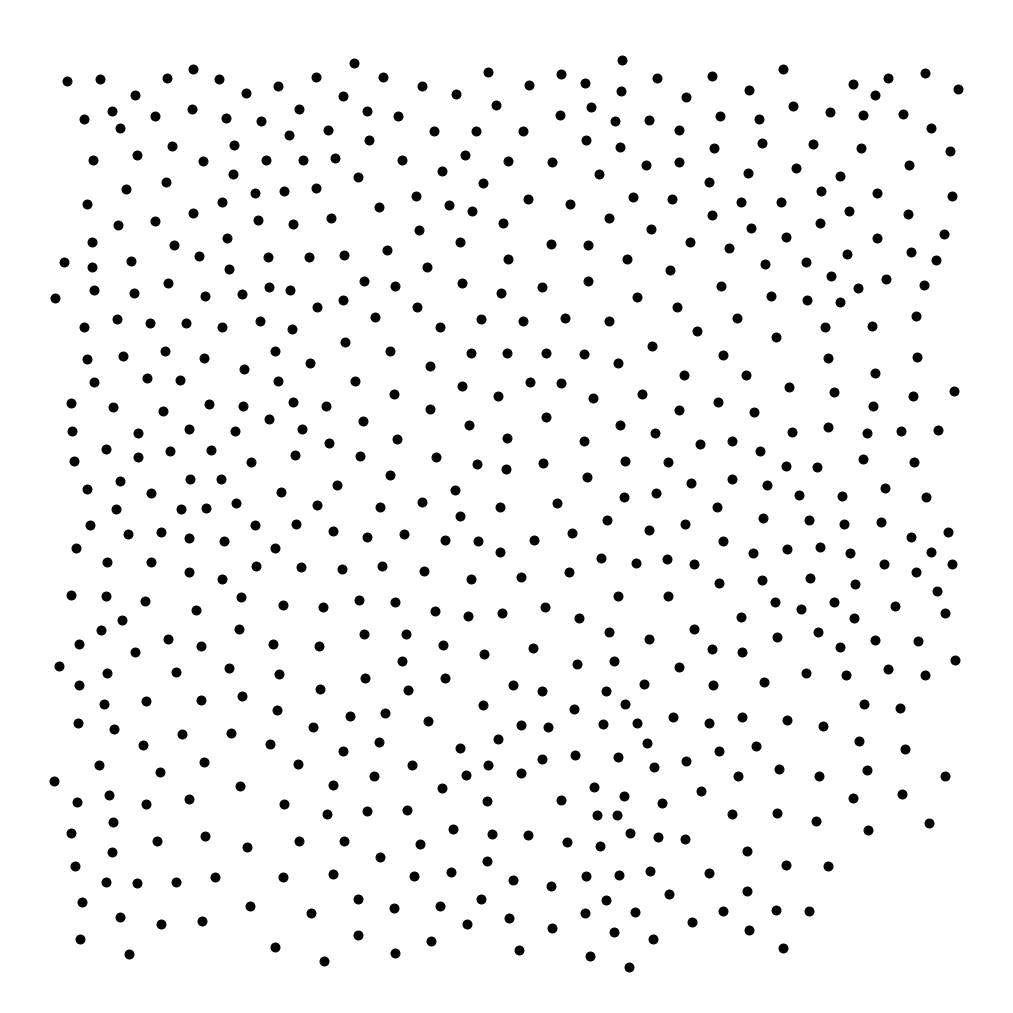

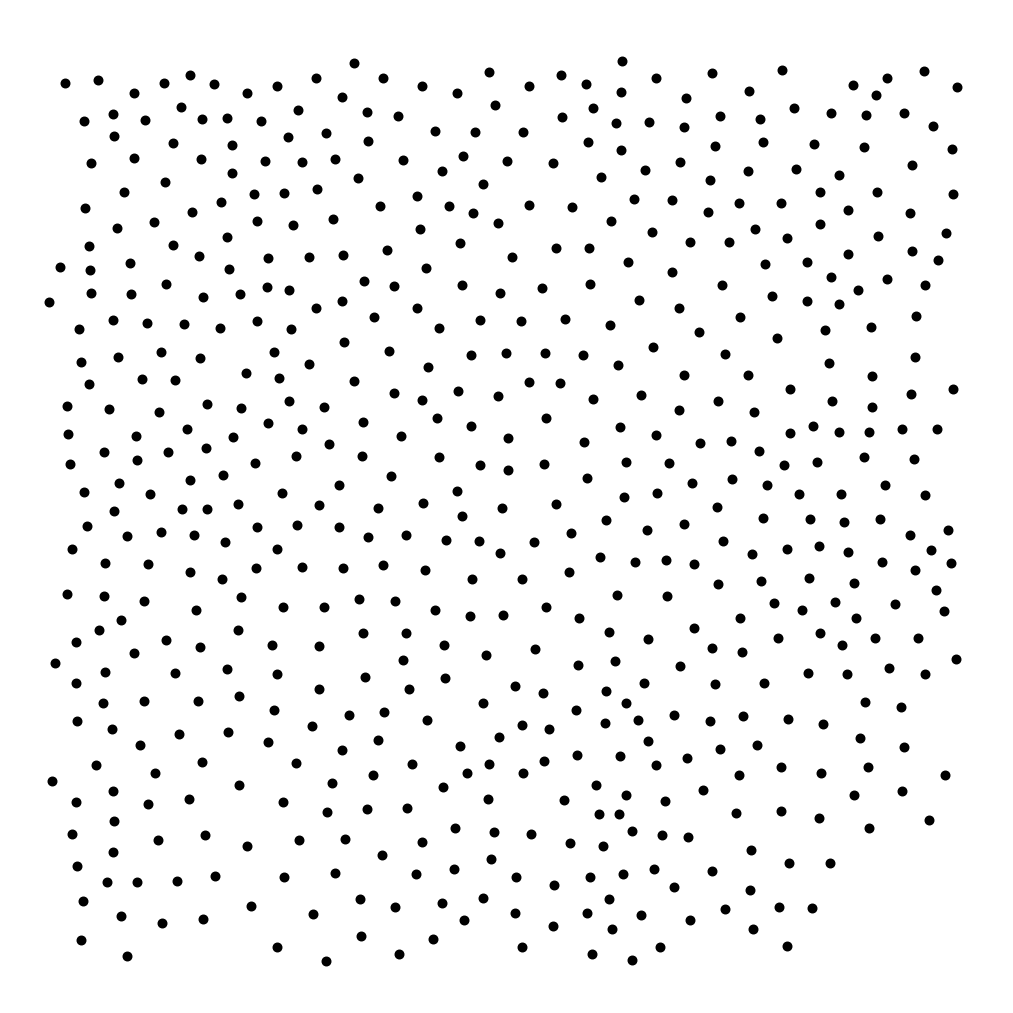

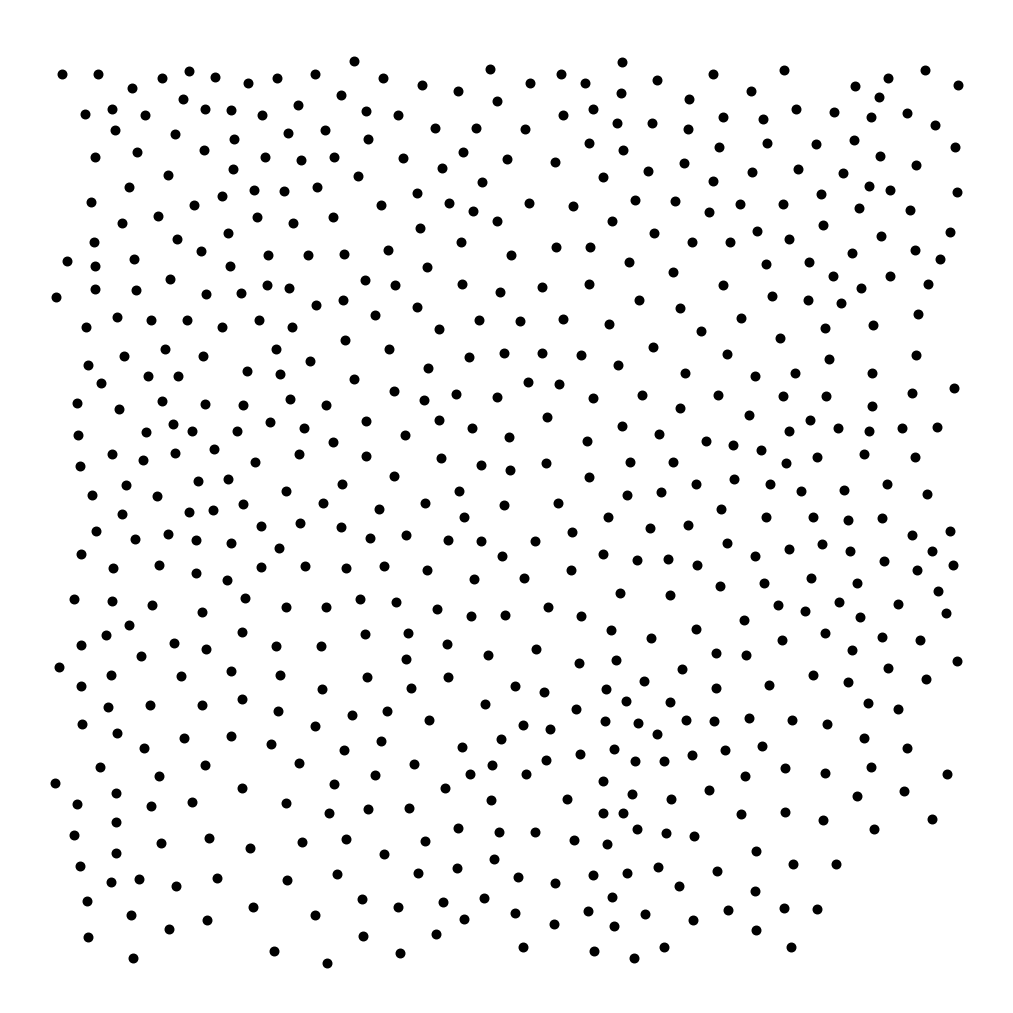

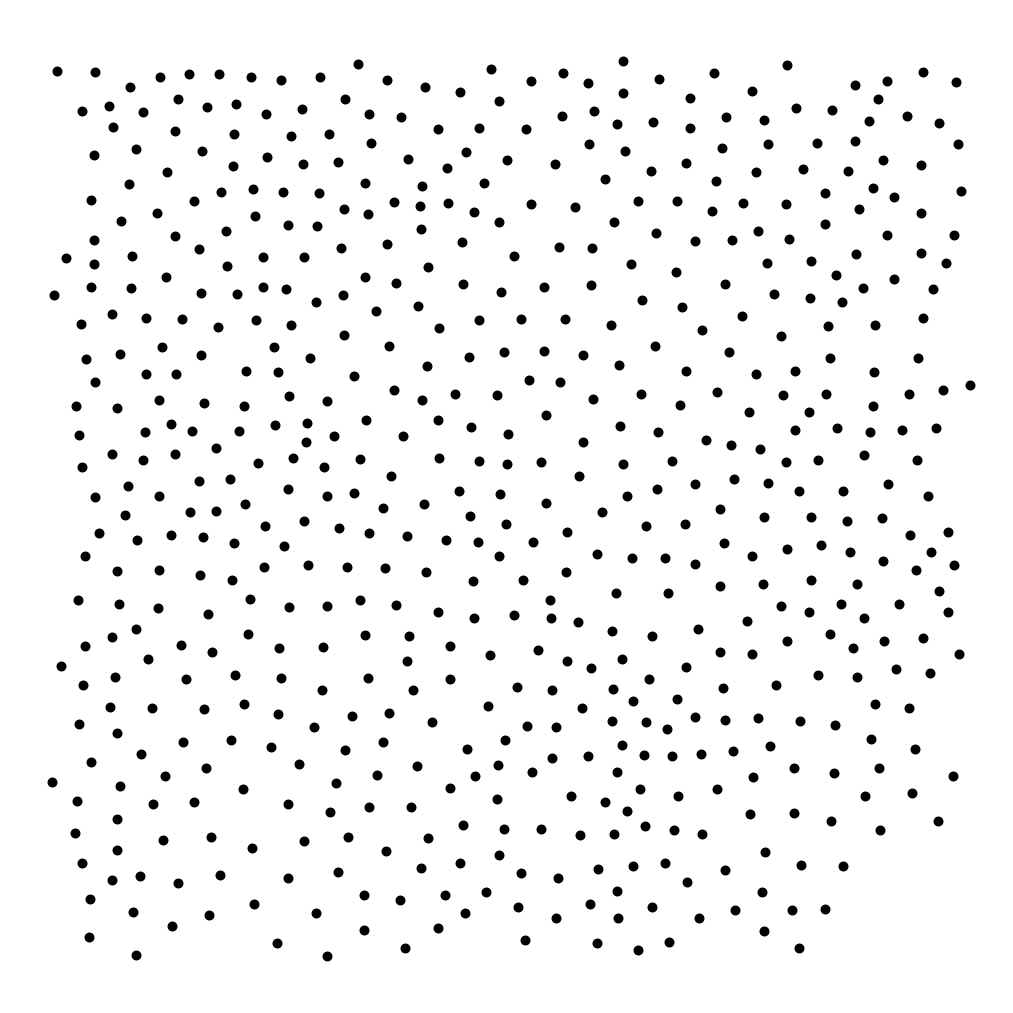

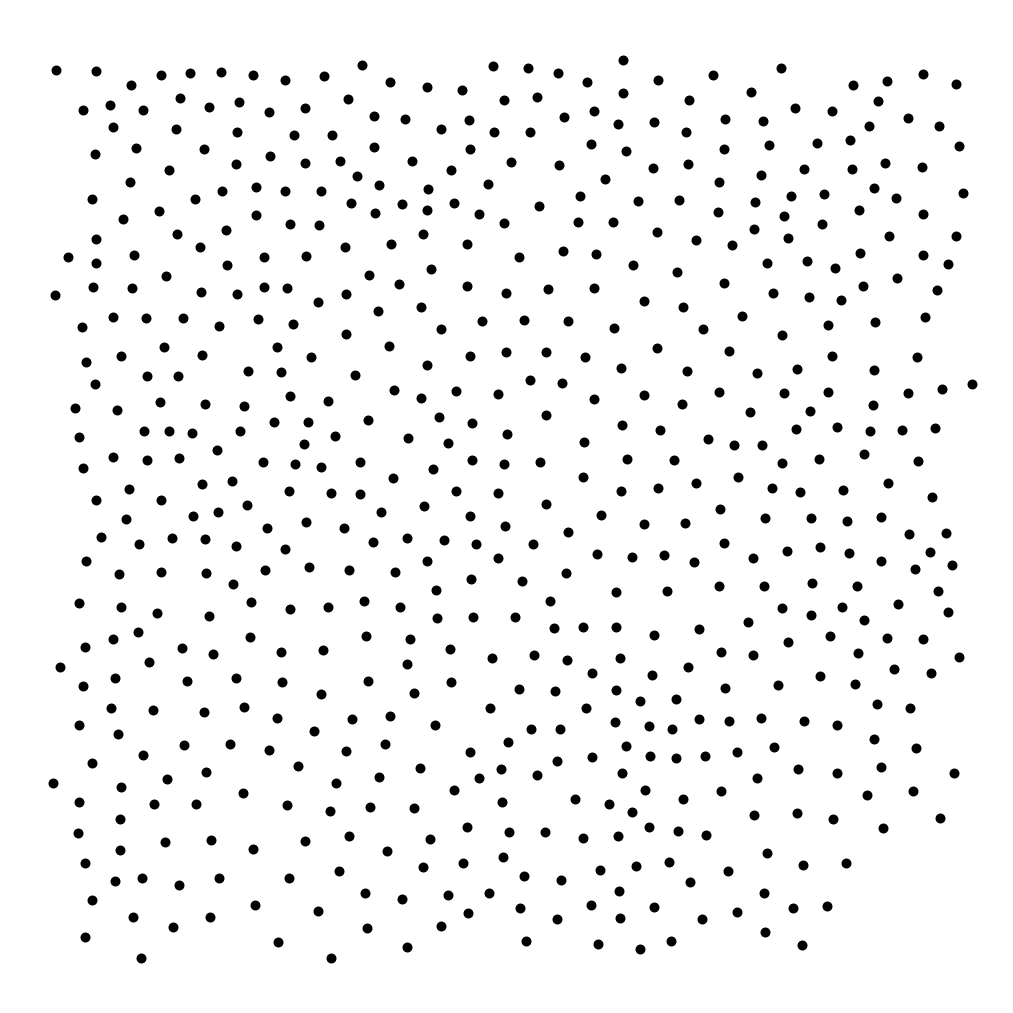

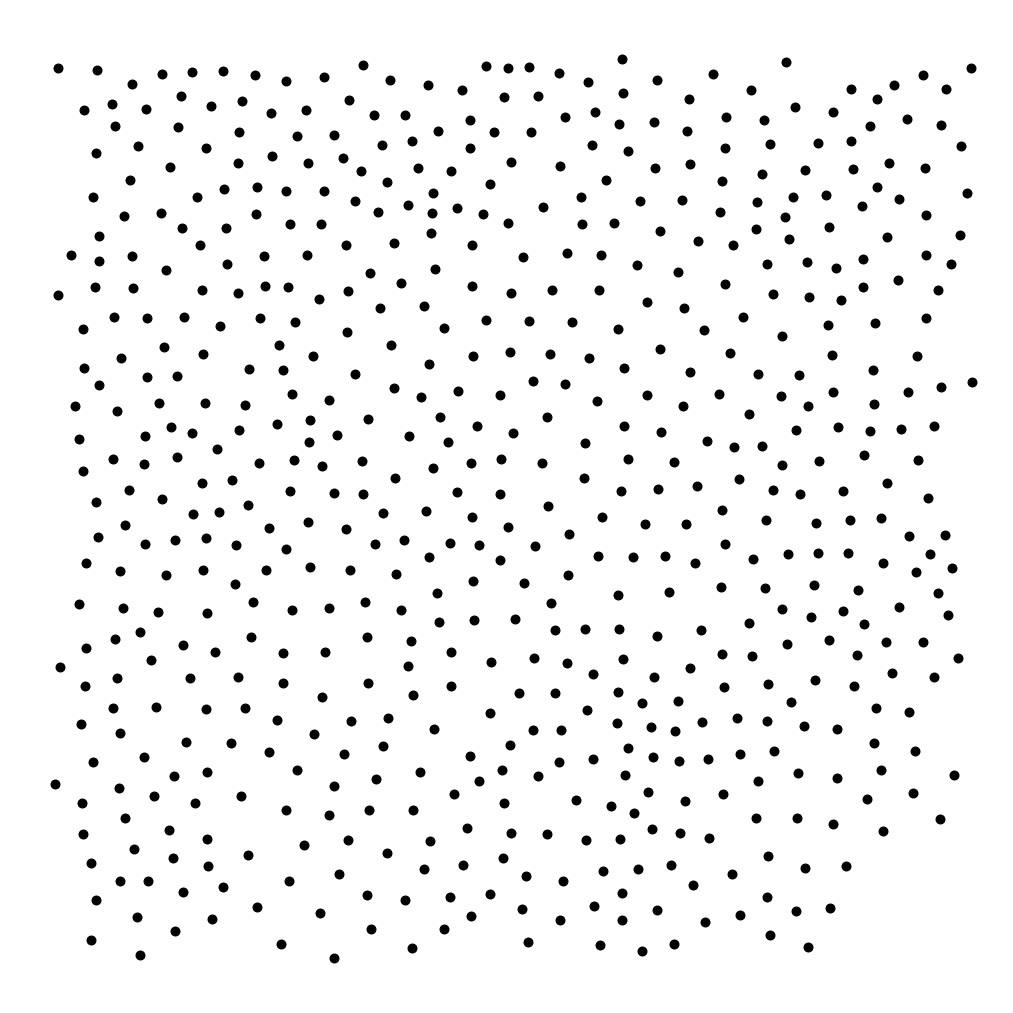

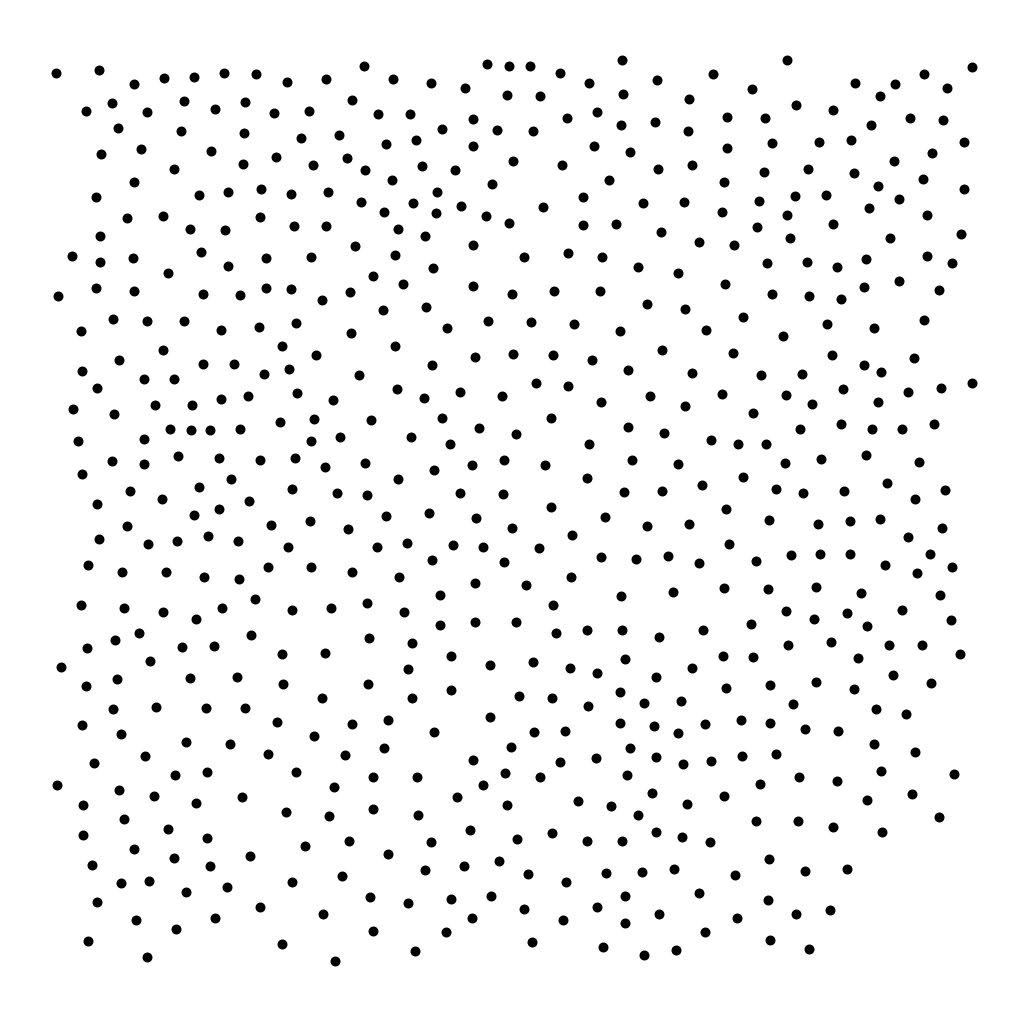

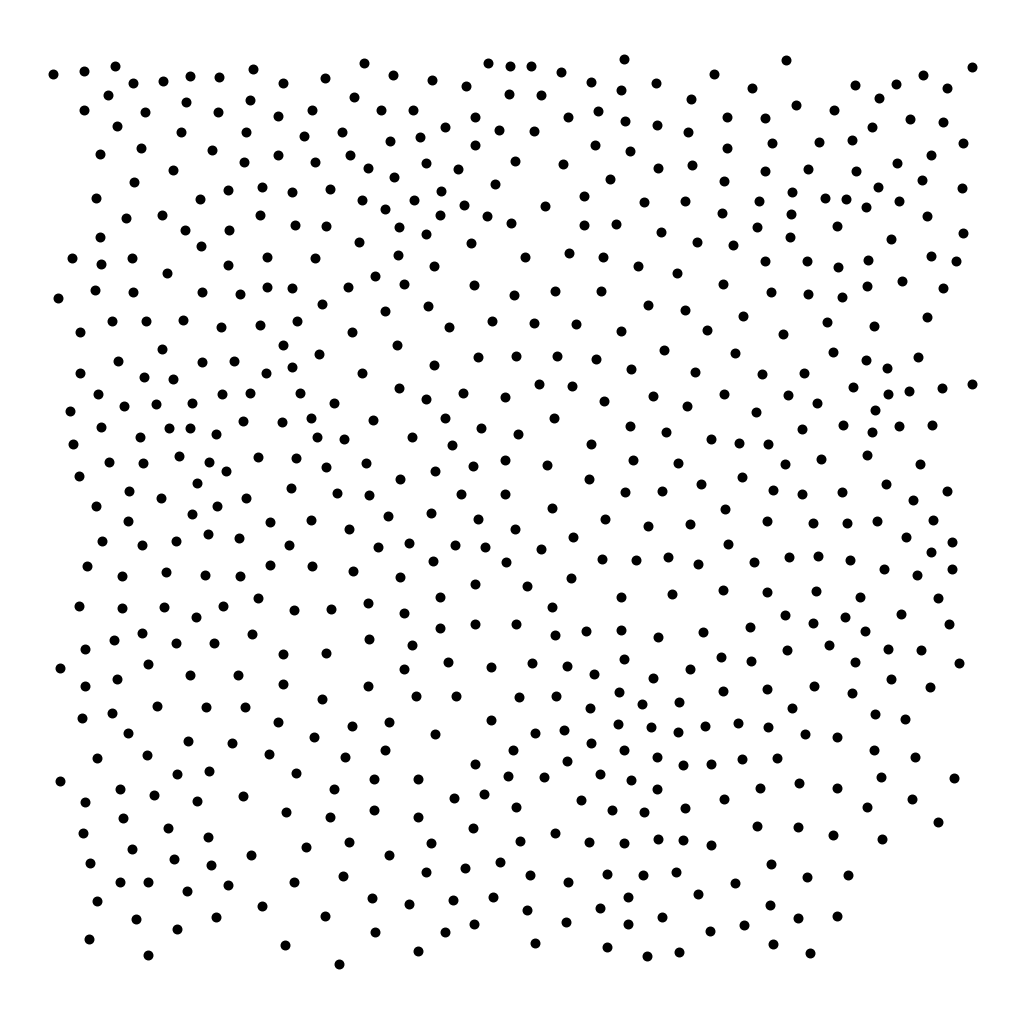

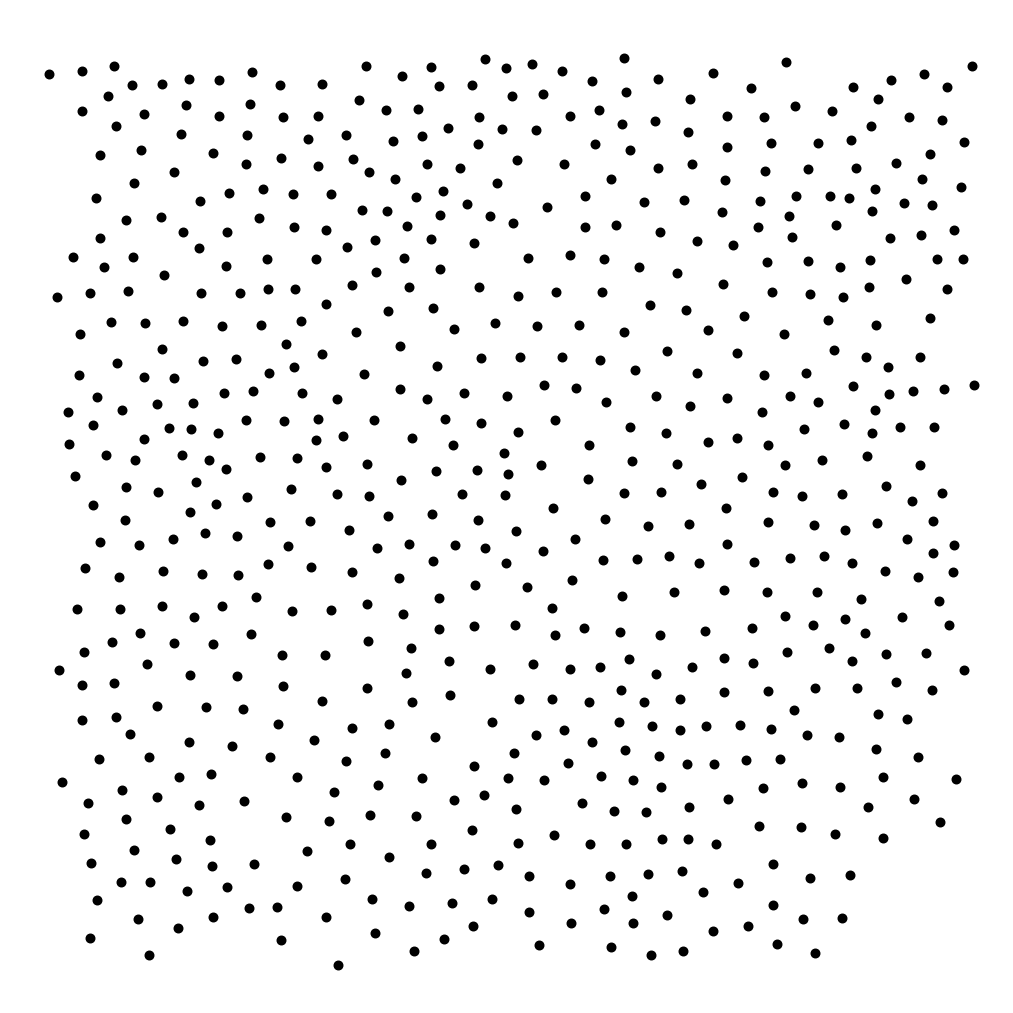

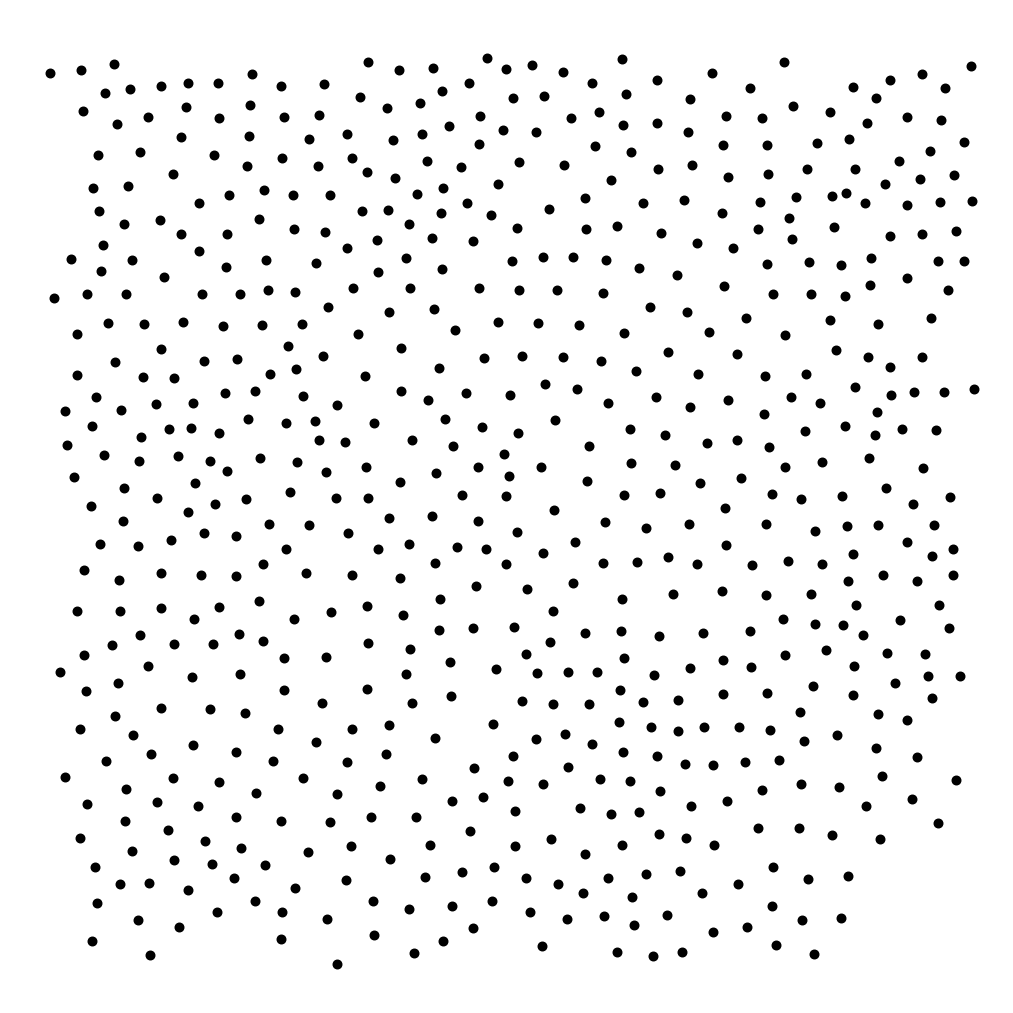

In [38]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)
    fig, ax=plt.subplots(frameon=False,figsize=(10,10), dpi=102.4,subplot_kw={'aspect': 'equal'})
    ax.scatter(cc[:,0], cc[:,1], c='black')
    ax.set_aspect('equal')
    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    #ax.axis('off')

    plt.xlim(0,1024)
    plt.ylim(0,1024)

    fig.patch.set_visible(False)
    ax.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # plt.gca().set_aspect('equal')
    fig.tight_layout()

    plt.savefig(plot_dir+'/cc_fr_'+str(i)+'.png', bbox_inches=0, pad_inches=0)

In [102]:
dat_df.cell_area_microns.min()

45.23978646225941

In [36]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].cell_area_microns
    cmap=sns.color_palette("Reds", as_cmap=True)
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(dat_df.cell_area_microns.min(), dat_df.cell_area_microns.max())
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('area', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    #plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/area_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [208]:
for i in range(len(mat_dir)):
    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)

    plot_variable=dat_df[dat_df.tm_frame==i].shape_parameter
    cmap="viridis"
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    ax.set_xlim(dat_df.cc_x.min()-30, dat_df.cc_x.max()+30)
    ax.set_ylim(dat_df.cc_y.min()-30, dat_df.cc_y.max()+30)

    ## For colormap of continuous data
    # polys=plot_polys(C, R, cc)
    # polys.set_facecolor('black')
    # ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(dat_df.shape_parameter.min(), dat_df.shape_parameter.max())
    #polys.set_alpha(1-dat_df[dat_df.tm_frame==i].circularity)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('shape_parameter', rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    #plot_alignment_axis(cc,np.array(dat_df[dat_df.tm_frame==i].major_shape_axis_alignment_rads))

    #plot_cell_id(cc)

    #ax.set_title(title) ###change title
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(plot_dir+'/shape_parameter_t_'+str(i*5)+'.png', dpi=300)
    plt.close()

In [115]:
dat_df[dat_df.divisions==0].cell_area_microns

0        196.331889
1        216.096844
2        192.964526
3        158.119642
4        190.475606
            ...    
12284    527.504695
12285    480.508023
12286    493.391846
12287    589.581295
12288    460.303847
Name: cell_area_microns, Length: 11147, dtype: float64

In [135]:
dat_df.groupby(['time','parent_id']).cell_area_microns.sum()/2

time  parent_id
5     252.0        280.589161
      262.0        226.638154
10    252.0        269.096206
      262.0        243.328560
15    226.0        339.591213
                      ...    
150   312.0        255.114330
      320.0        276.416559
      346.0        292.521338
      350.0        304.526718
      376.0        351.157372
Name: cell_area_microns, Length: 571, dtype: float64

In [136]:
no_div=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time==len(mat_dir))[0])]

div_cells=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time<len(mat_dir))[0])]

In [142]:
orig_cells=dat_df[dat_df.cell_id_new.isin(dat_df[dat_df.time==0].cell_id_new)]
daughter_cells=dat_df[~dat_df.cell_id_new.isin(dat_df[dat_df.time==0].cell_id_new)]

In [144]:
dat_df.groupby(['time','parent_id']).cell_area_microns.sum()/2

time  parent_id
5     252.0        280.589161
      262.0        226.638154
10    252.0        269.096206
      262.0        243.328560
15    226.0        339.591213
                      ...    
150   312.0        255.114330
      320.0        276.416559
      346.0        292.521338
      350.0        304.526718
      376.0        351.157372
Name: cell_area_microns, Length: 571, dtype: float64

In [141]:
dat_df

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal
0,0.0,57.243836,196.331889,4.085388,0.960859,4.0,1.425497,-123.647039,-385.624397,374,2539,0,0,NaN,0,1.425497
1,1.0,60.465160,216.096844,4.113211,0.646293,4.0,2.973255,-215.147039,-351.374397,360,2525,0,0,NaN,0,0.168337
2,2.0,57.123312,192.964526,4.112204,0.757297,4.0,2.007499,131.852961,-310.374397,339,2501,0,0,NaN,0,1.134094
3,3.0,52.640732,158.119642,4.186287,0.462642,4.0,1.835798,166.102961,-272.374397,321,2473,0,0,NaN,0,1.305794
4,4.0,56.545391,190.475606,4.097109,0.684893,4.0,2.879351,103.352961,-191.124397,280,2410,0,0,NaN,0,0.262242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12284,401.0,86.071436,527.504695,3.747537,0.479526,8.0,0.711765,176.553264,135.798153,120,14343,150,30,NaN,0,0.711765
12285,402.0,82.891789,480.508023,3.781475,0.465094,8.0,2.221361,284.803264,158.173153,108,14324,150,30,NaN,0,0.920231
12286,403.0,81.920020,493.391846,3.688027,0.786120,8.0,2.544464,-157.071736,163.423153,110,14318,150,30,NaN,0,0.597128
12287,404.0,89.826745,589.581295,3.699421,0.696678,8.0,1.552711,-180.196736,352.048153,27,14133,150,30,NaN,0,1.552711


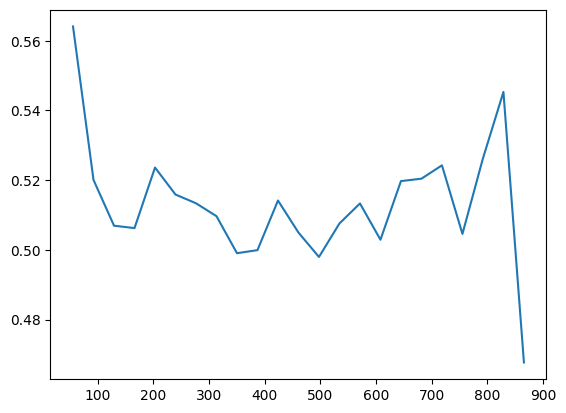

In [226]:
shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==0].major_shape_axis_alignment_rads.values))**2
r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==0].cc_x.values, dat_df[dat_df.time==0].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==0].cc_y.values, dat_df[dat_df.time==0].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'cos_sq': shape_cos_sq[upper_triangle]})
n=26
bins=np.linspace(c_func_shape.r.min(),c_func_shape.r.max(), n)
#bins=np.arange(0, c_func_shape.r.max(), 30)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.cos_sq.mean()
    shape_corr.append(mean_corr)

plt.plot((bins[:-1]+np.diff(bins))[:-2], shape_corr[:-2])

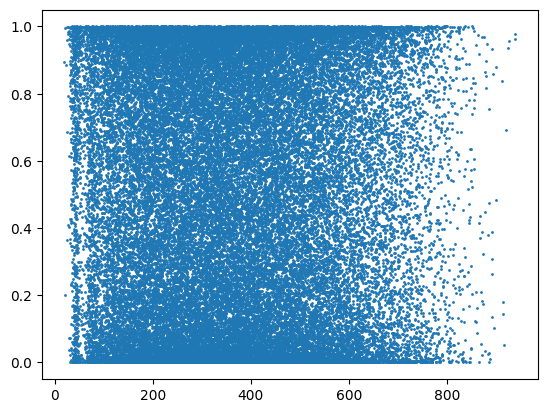

In [227]:
plt.scatter(c_func_shape.r, c_func_shape.cos_sq, s=1)

(array([ 792., 1343., 1956., 2411., 2792., 3035., 3285., 3387., 3413.,
        3421., 3357., 3237., 3065., 2838., 2503., 2156., 1826., 1413.,
         962.,  568.,  353.,  206.,  107.,   58.,   25.,    7.]),
 array([ 20.00889825,  56.87614895,  93.74339965, 130.61065035,
        167.47790105, 204.34515175, 241.21240245, 278.07965316,
        314.94690386, 351.81415456, 388.68140526, 425.54865596,
        462.41590666, 499.28315736, 536.15040806, 573.01765877,
        609.88490947, 646.75216017, 683.61941087, 720.48666157,
        757.35391227, 794.22116297, 831.08841367, 867.95566438,
        904.82291508, 941.69016578, 978.55741648]),
 <BarContainer object of 26 artists>)

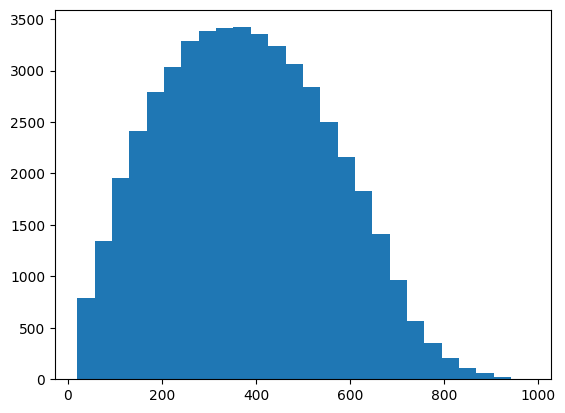

In [223]:
plt.hist(c_func_shape.r, bins=26)

In [10]:
B=B_final

In [11]:
N_c=np.shape(B)[0]


all_nn=[]
for i in range(N_c):
    nn=[]
    all_cells=[]
    nn.append([i])
    all_cells.append(i)

    shell1=list(np.unique(np.where(B[:,np.where(B[i,:]!=0)[0]]!=0)[0])) #1st shell of neighbouring cells
    shell1.remove(i)

    nn.append(list(shell1))
    all_cells.extend(shell1)

    while len(all_cells) < N_c: 
        shell=[]
        for n in nn[-1]: #for each cell in previous shell find their nns not in previous cell
            nn_i=np.unique(np.where(B[:,np.where(B[n,:]!=0)[0]]!=0)[0])
            shell.append(set(nn_i).difference(all_cells))
        shell=set([x for xs in shell for x in xs]) #get unique cells
        nn.append(list(shell))
        all_cells.extend(list(shell))
    
    all_nn.append(nn)

shell_matrix=np.array([[[x for x, xs in enumerate(all_nn[m]) if n in xs][0] for n in range(N_c)] for m in range(N_c)])

In [12]:
shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.time==145].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==145].major_shape_axis_alignment_rads.values))**2
upper_triangle = np.triu_indices_from(shell_matrix, 1)
c_func_shape_shell=pd.DataFrame({'shell': shell_matrix[upper_triangle],
                        'cos_sq': shape_cos_sq[upper_triangle]})


Text(0.5, 1.0, 'time = 145')

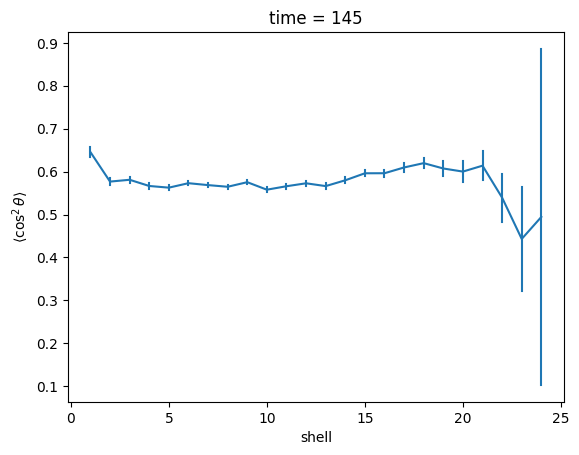

In [13]:
sns.lineplot(data=c_func_shape_shell, y='cos_sq', x='shell',err_style='bars', errorbar='se')
plt.ylabel(r'$\langle\cos ^2 \theta\rangle$')
plt.title('time = '+str(dat_df.time.max()))


In [480]:
cell_dict=pd.Series(dat_df.cell_id_new.values,index=dat_df.cell_id_old.astype(int)).to_dict()

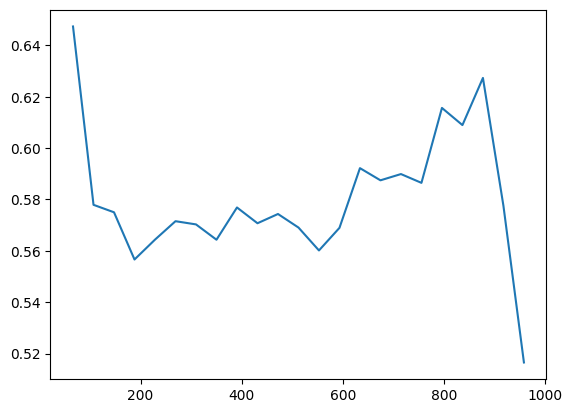

In [534]:
shape_cos_sq=np.cos(np.subtract.outer(dat_df[dat_df.time==145].major_shape_axis_alignment_rads.values,dat_df[dat_df.time==145].major_shape_axis_alignment_rads.values))**2



r = np.sqrt(np.subtract.outer(dat_df[dat_df.time==145].cc_x.values, dat_df[dat_df.time==145].cc_x.values)**2 +
                np.subtract.outer(dat_df[dat_df.time==145].cc_y.values, dat_df[dat_df.time==145].cc_y.values)**2)
upper_triangle = np.triu_indices_from(r, 1)
c_func_shape=pd.DataFrame({'r': r[upper_triangle],
                        'cos_sq': shape_cos_sq[upper_triangle]})
n=26
bins=np.linspace(c_func_shape.r.min(),c_func_shape.r.max(), n)
#bins=np.arange(0, c_func_shape.r.max(), 30)
shape_corr=[]
for i in range(1,len(bins)):
    c_bin=c_func_shape[(c_func_shape.r>bins[i-1])&(c_func_shape.r<=bins[i])]
    mean_corr=c_bin.cos_sq.mean()
    shape_corr.append(mean_corr)

plt.plot((bins[:-1]+np.diff(bins))[:-2], shape_corr[:-2])


In [477]:
dat_df

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,angle_horizontal
0,0.0,20.351758,18.154477,4.776503,0.369100,3.0,1.069451,0.304263,213.151272,38,23130,0,0,1.069451
1,1.0,48.876293,144.650191,4.063860,0.665094,4.0,1.463043,-54.862403,-130.182062,195,24026,0,0,1.463043
2,2.0,62.530105,217.268101,4.242200,0.391993,4.0,0.661316,84.137597,104.817938,83,23428,0,0,0.661316
3,3.0,57.527869,191.500455,4.157128,0.614371,4.0,0.937894,57.637597,312.817938,291,22752,0,0,0.937894
4,4.0,68.516561,315.800063,3.855578,0.689709,5.0,1.141720,66.437597,-412.782062,240,24448,0,0,1.141720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853,328.0,88.915536,575.086994,3.707754,0.841900,8.0,0.442826,-219.153071,-16.076519,121,31540,145,29,0.442826
9854,329.0,99.375915,727.203946,3.685132,0.584069,8.0,0.516918,219.846929,49.923481,103,31488,145,29,0.516918
9855,330.0,103.232649,755.753326,3.755148,0.816508,8.0,0.147658,19.721929,62.798481,90,31472,145,29,0.147658
9856,331.0,96.921647,685.185115,3.702686,0.614774,8.0,2.993085,33.096929,263.673481,301,31206,145,29,0.148508


In [400]:
len(nn[-1])
len(nn)

22

In [369]:
dat_df[dat_df.time==90].count()

cell_id_old                        333
cell_perimeter_microns             333
cell_area_microns                  333
shape_parameter                    333
circularity                        333
cell_edge_count                    333
major_shape_axis_alignment_rads    333
cc_x                               333
cc_y                               333
cell_id_new                        333
spot_id                            333
time                               333
tm_frame                           333
angle_horizontal                   333
dtype: int64

In [246]:
test=[0,94, 96,  99, 103, 259, 324]

In [270]:
[a for a in test if a not in [x for xs in nn for x in xs]]

[94, 96, 103]

In [18]:
shell_matrix[0]

array([ 0,  6,  8, 17, 17,  2,  3,  3,  9,  4,  7,  2,  6,  9,  6,  3, 12,
        9, 11,  4,  8,  9, 10,  6, 11,  5,  5,  5,  8,  6,  8, 11,  6, 10,
        7,  7,  7, 12, 10,  8,  8, 11, 13,  9, 11, 15, 10, 10, 10, 10, 14,
       13, 11, 11, 11, 11, 12, 14, 11, 12, 17, 18, 16, 16, 14, 13, 13, 14,
       14, 16, 13, 14, 15, 17, 16, 16, 16, 20, 19, 21, 18, 17, 18, 21, 17,
       20, 17, 11, 10,  6,  9,  5,  2,  4,  2,  2,  2,  8, 10,  1, 11,  5,
        8,  2,  5,  7,  1,  3,  2,  4,  4,  2,  2, 11,  3,  7,  2,  8,  4,
        3,  3, 11, 12, 10,  5,  3,  4,  5,  4,  8,  4,  4,  5,  4,  9,  5,
        5,  8,  6,  5, 10,  7,  8, 12,  7,  9,  7, 11,  8, 10, 10,  7,  7,
       12,  7, 13,  8, 13, 11,  8,  8,  8,  8, 13,  8, 11, 14,  9, 12, 13,
       10,  9, 14, 13,  9, 13,  9, 11, 14, 12, 14, 12, 11, 15, 14, 16, 11,
       13, 11, 12, 16, 16, 14, 13, 14, 14, 15, 15, 17, 17, 14, 13, 14, 13,
       14, 12, 12, 12, 13, 15, 14, 14, 16, 18, 16, 15, 15, 15, 15, 19, 17,
       16, 16, 20, 16, 15

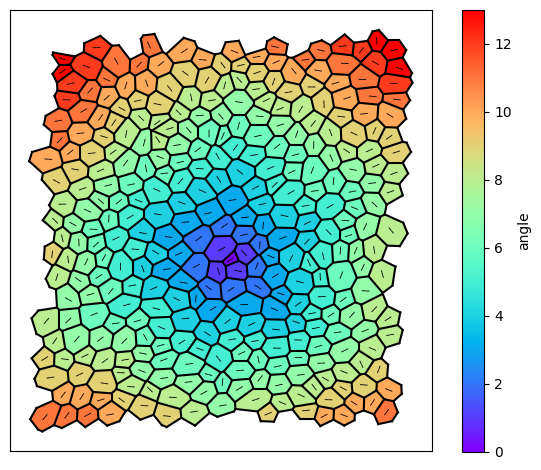

In [39]:

plot_variable=shell_matrix[2]
cmap='rainbow'
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

## For colormap of continuous data
# polys=plot_polys(C, R, cc)
# polys.set_facecolor('black')
# ax.add_collection(polys) 

polys=plot_polys(C_final, R_final, cc_final)
#polys.set_facecolor('black')
polys.set_array(plot_variable)
polys.set_cmap(cmap) ###set polygon colourmap here
#polys.set_clim(0, np.pi)
#polys.set_alpha(1-dat_df[dat_df.time==0].circularity)
ax.add_collection(polys) 
cbar = fig.colorbar(polys, ax=ax)
cbar.ax.set_ylabel('angle', rotation=90) ###set colorbar label




ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

plot_edges(A_final, R_final)

plot_alignment_axis(cc_final,np.array(dat_df[dat_df.time==145].major_shape_axis_alignment_rads))

#plot_cell_id(cc)

#ax.set_title(title) ###change title
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig(plot_dir+'/shell_test_t_.png', dpi=300)

